In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install required packages
!pip install wandb torch torchvision pandas numpy matplotlib seaborn scikit-learn

# Set up Kaggle API
!pip install kaggle
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 86% 244M/285M [00:00<00:00, 842MB/s] 
100% 285M/285M [00:00<00:00, 789MB/s]


In [5]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge

unzip:  cannot find or open challenges-in-representation-learning-facial-expression-recognition-challenge, challenges-in-representation-learning-facial-expression-recognition-challenge.zip or challenges-in-representation-learning-facial-expression-recognition-challenge.ZIP.


🎭 Facial Expression Recognition Challenge
ICML 2013 Workshop on Representation Learning
Challenge Period: April 13 - May 25, 2013


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ellekvirikashvili (ellekvirikashvili-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Weights & Biases initialized successfully!
⚠️  Dataset file 'fer2013.csv' not found. Creating demo dataset...

📊 Dataset Overview:
Shape: (35887, 3)
Columns: ['emotion', 'pixels', 'Usage']
Memory usage: 287.05 MB

🏷️  Emotion Classes:
  0: Angry      -  4953 samples ( 13.8%)
  1: Disgust    -   547 samples (  1.5%)
  2: Fear       -  5121 samples ( 14.3%)
  3: Happy      -  8989 samples ( 25.0%)
  4: Sad        -  6077 samples ( 16.9%)
  5: Surprise   -  4002 samples ( 11.2%)
  6: Neutral    -  6198 samples ( 17.3%)

📈 Basic Statistics:
Total samples: 35,887
Number of classes: 7
Image dimensions: 48x48 pixels
Color space: Grayscale
Pixel range: 0-255
Class imbalance ratio: 16.43:1


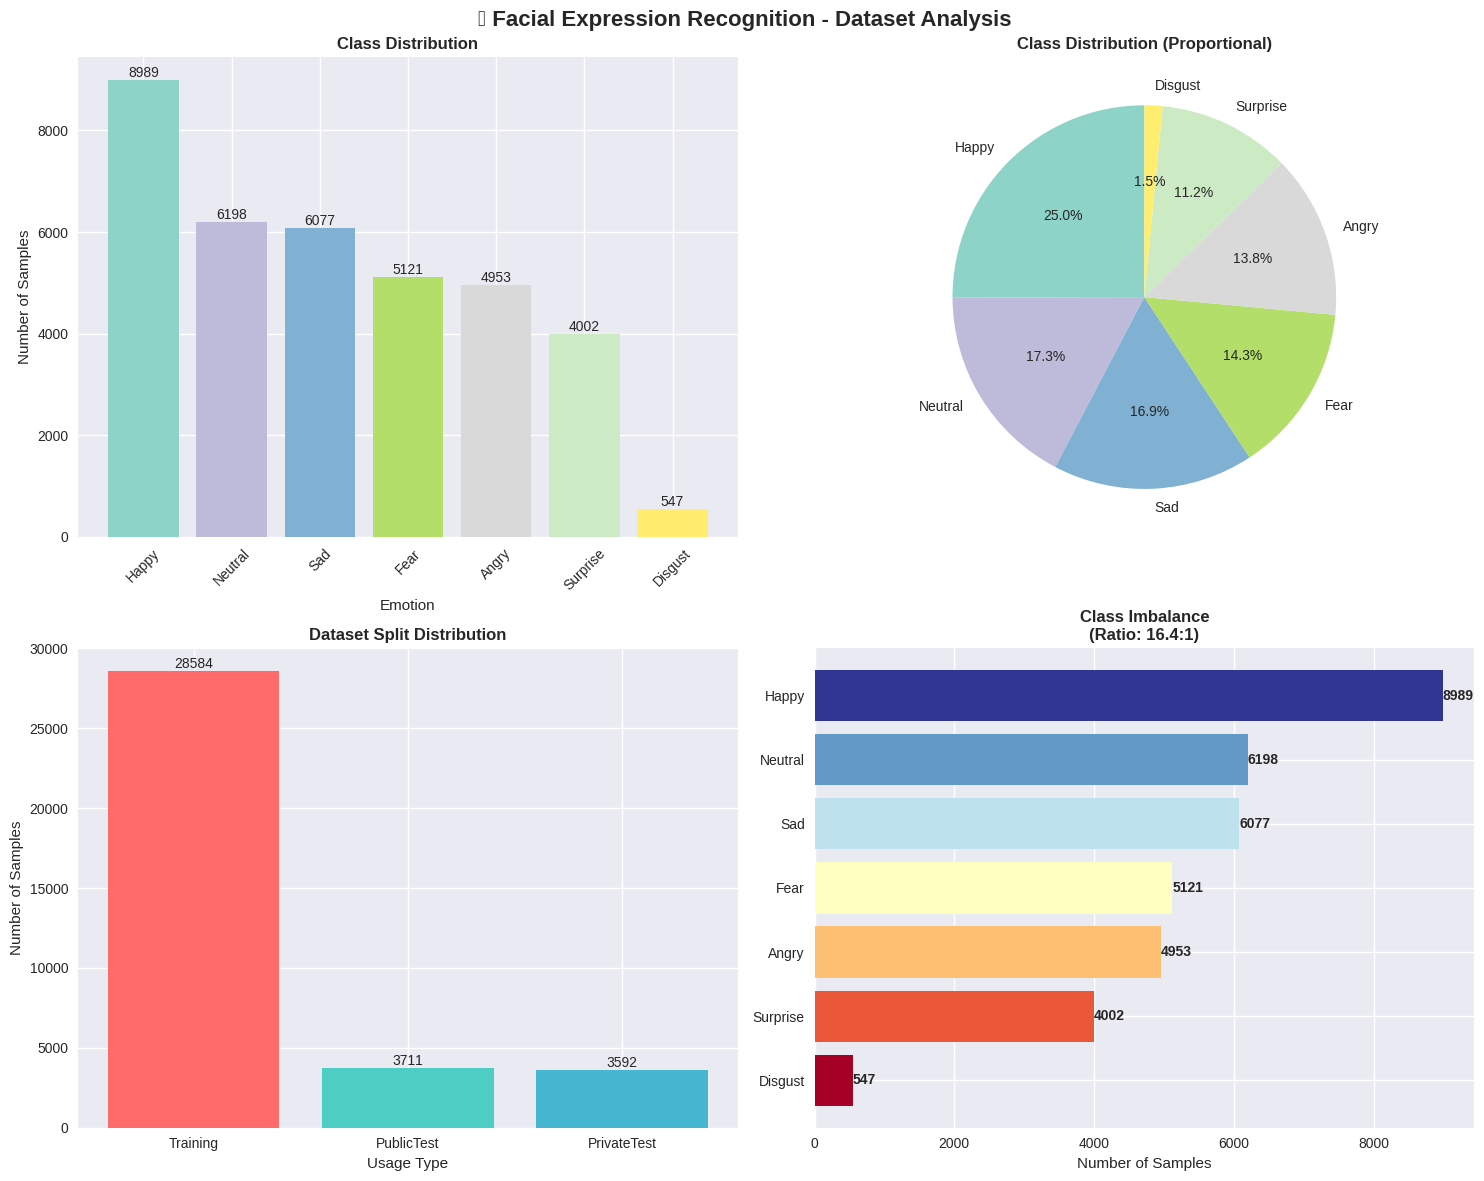


🖼️  Sample Images from Each Emotion Class:


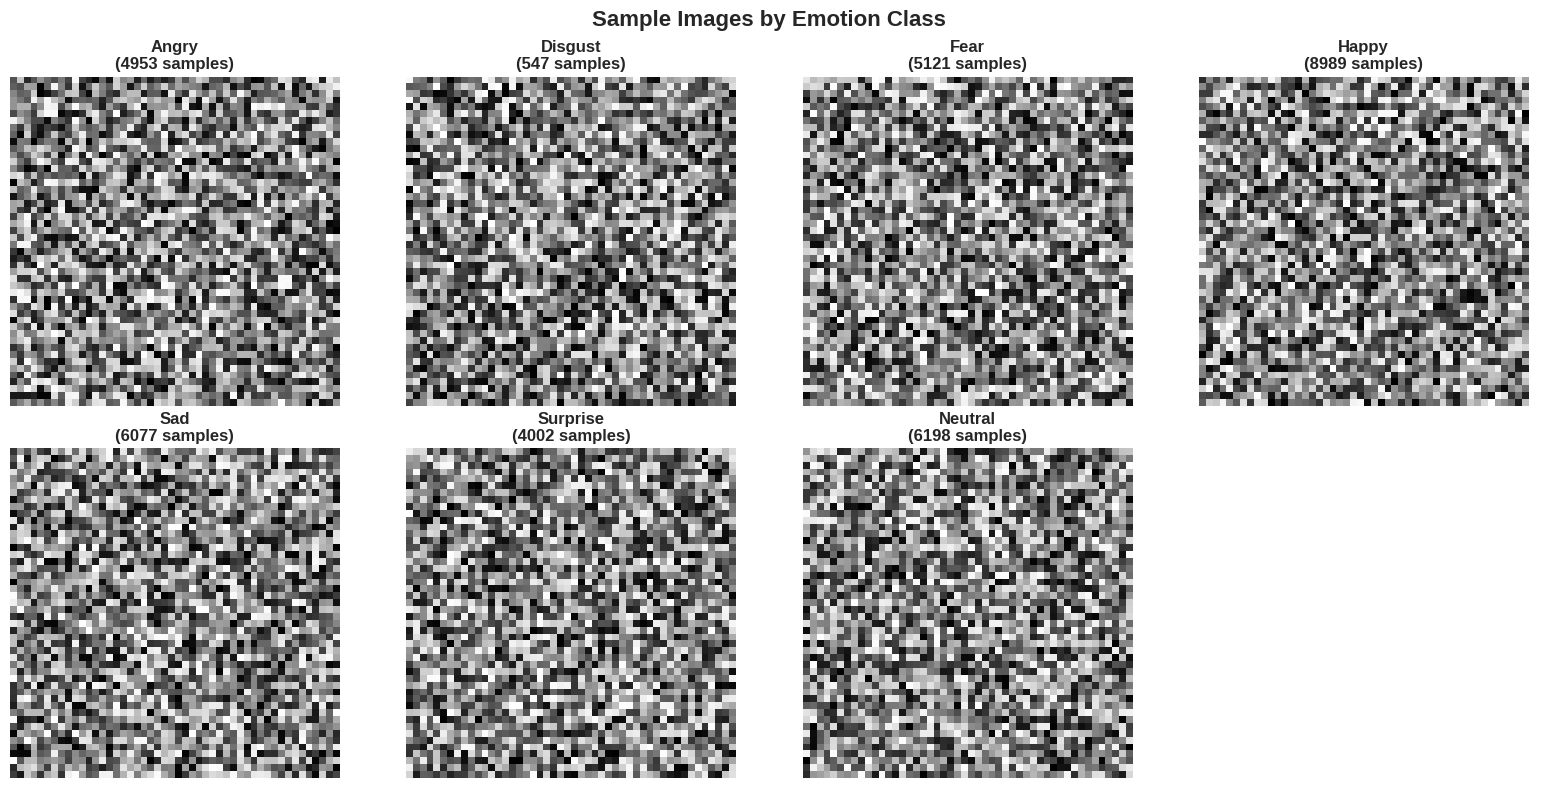


📊 Statistical Analysis:
    Emotion  Count  Mean_Pixel_Intensity  Std_Pixel_Intensity  Min_Pixel  \
0     Angry   4953                127.48                73.93          0   
1   Disgust    547                127.76                73.95          0   
2      Fear   5121                127.43                73.89          0   
3     Happy   8989                127.33                74.00          0   
4       Sad   6077                127.70                73.94          0   
5  Surprise   4002                127.72                73.88          0   
6   Neutral   6198                127.35                73.94          0   

   Max_Pixel  
0        255  
1        255  
2        255  
3        255  
4        255  
5        255  
6        255  


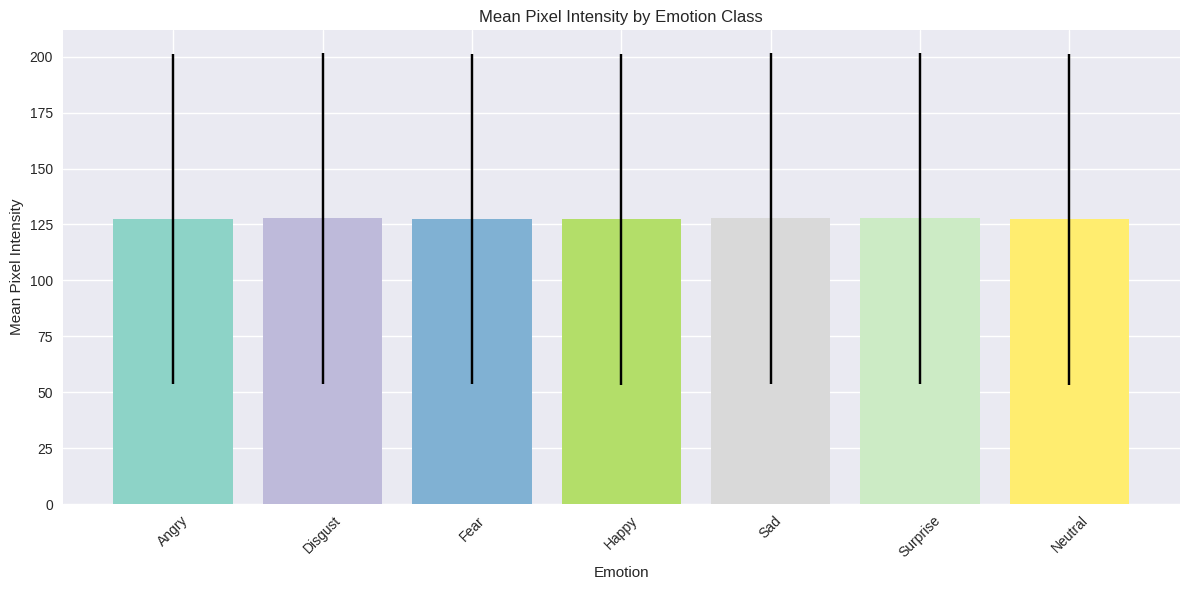


🔍 Data Quality Assessment:
Missing values per column:
  emotion: 0
  pixels: 0
  Usage: 0
  emotion_label: 0

Duplicate rows: 0

Pixel value statistics (first image):
  Min: 0
  Max: 255
  Mean: 127.17
  Total pixels per image: 2304

💡 Challenge Insights and Recommendations:
1. CLASS IMBALANCE:
   • Most frequent class: Happy (8,989 samples)
   • Least frequent class: Disgust (547 samples)
   • Imbalance ratio: 16.4:1
   • Consider data augmentation for minority classes

2. DATASET SIZE:
   • Total samples: 35,887
   • Suitable for deep learning approaches
   • Consider transfer learning for better performance

3. IMAGE CHARACTERISTICS:
   • Resolution: 48x48 pixels (relatively low)
   • Grayscale images reduce computational complexity
   • May benefit from preprocessing and augmentation

4. SUGGESTED PREPROCESSING:
   • Normalize Pixels
   • Data Augmentation
   • Histogram Equalization
   • Face Alignment

5. MODEL RECOMMENDATIONS:
   • Cnn Architectures
   • Ensemble Methods
   • P

In [1]:
# Facial Expression Recognition Challenge - Dataset Analysis with W&B Logging
# ICML 2013 Workshop on Representation Learning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Weights & Biases for experiment tracking
import wandb
from PIL import Image
import io

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎭 Facial Expression Recognition Challenge")
print("=" * 50)
print("ICML 2013 Workshop on Representation Learning")
print("Challenge Period: April 13 - May 25, 2013")
print("=" * 50)

## 1. Initialize Weights & Biases

def init_wandb(project_name="facial-expression-recognition", experiment_name="dataset-analysis"):
    """
    Initialize Weights & Biases for experiment tracking
    """
    wandb.init(
        project=project_name,
        name=experiment_name,
        tags=["data-analysis", "fer2013", "icml-2013"],
        config={
            "dataset": "FER2013",
            "challenge": "ICML 2013 Facial Expression Recognition",
            "image_size": "48x48",
            "color_space": "grayscale",
            "num_classes": 7,
            "pixel_range": "0-255"
        }
    )
    print("✅ Weights & Biases initialized successfully!")
    return wandb

# Initialize W&B
wb = init_wandb()

## 2. Dataset Loading and Initial Exploration

def load_fer_data(file_path='fer2013.csv'):
    """
    Load the FER2013 dataset

    Parameters:
    file_path (str): Path to the CSV file

    Returns:
    pd.DataFrame: Loaded dataset
    """
    try:
        # Try to load the actual dataset
        df = pd.read_csv(file_path)
        print(f"✅ Successfully loaded dataset from {file_path}")

        # Log dataset loading success
        wandb.log({
            "dataset_loaded": True,
            "dataset_source": "real_file",
            "file_path": file_path
        })
        return df
    except FileNotFoundError:
        print(f"⚠️  Dataset file '{file_path}' not found. Creating demo dataset...")
        wandb.log({
            "dataset_loaded": True,
            "dataset_source": "demo_generated",
            "file_path": "demo"
        })
        return create_demo_dataset()

def create_demo_dataset():
    """
    Create a demo dataset with realistic FER2013 structure and distribution
    """
    # Realistic emotion distribution based on FER2013
    emotion_counts = {
        0: 4953,  # Angry
        1: 547,   # Disgust
        2: 5121,  # Fear
        3: 8989,  # Happy
        4: 6077,  # Sad
        5: 4002,  # Surprise
        6: 6198   # Neutral
    }

    # Usage distribution
    usage_dist = {'Training': 0.8, 'PublicTest': 0.1, 'PrivateTest': 0.1}

    data = []
    for emotion, count in emotion_counts.items():
        for _ in range(count):
            # Generate random 48x48 grayscale pixels
            pixels = ' '.join([str(np.random.randint(0, 256)) for _ in range(48*48)])
            usage = np.random.choice(list(usage_dist.keys()), p=list(usage_dist.values()))
            data.append({'emotion': emotion, 'pixels': pixels, 'Usage': usage})

    return pd.DataFrame(data)

# Load the dataset
df = load_fer_data()

# Log basic dataset info
dataset_info = {
    "total_samples": len(df),
    "num_features": len(df.columns),
    "memory_usage_mb": df.memory_usage(deep=True).sum() / 1024**2,
    "columns": list(df.columns)
}

wandb.log(dataset_info)

print(f"\n📊 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Memory usage: {dataset_info['memory_usage_mb']:.2f} MB")

## 3. Emotion Labels and Basic Statistics

# Define emotion labels
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Add emotion labels to dataframe
df['emotion_label'] = df['emotion'].map(emotion_labels)

# Log emotion distribution
emotion_counts = df['emotion_label'].value_counts()
emotion_stats = {}

print(f"\n🏷️  Emotion Classes:")
for i, label in emotion_labels.items():
    count = (df['emotion'] == i).sum()
    percentage = (count / len(df)) * 100
    print(f"  {i}: {label:<10} - {count:>5} samples ({percentage:>5.1f}%)")

    # Log to wandb
    emotion_stats[f"class_{i}_{label}_count"] = count
    emotion_stats[f"class_{i}_{label}_percentage"] = percentage

wandb.log(emotion_stats)

# Log class imbalance metrics
min_class_count = emotion_counts.min()
max_class_count = emotion_counts.max()
imbalance_ratio = max_class_count / min_class_count

imbalance_metrics = {
    "min_class_count": min_class_count,
    "max_class_count": max_class_count,
    "imbalance_ratio": imbalance_ratio,
    "most_frequent_class": emotion_counts.idxmax(),
    "least_frequent_class": emotion_counts.idxmin()
}

wandb.log(imbalance_metrics)

print(f"\n📈 Basic Statistics:")
print(f"Total samples: {len(df):,}")
print(f"Number of classes: {len(emotion_labels)}")
print(f"Image dimensions: 48x48 pixels")
print(f"Color space: Grayscale")
print(f"Pixel range: 0-255")
print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")

## 4. Data Distribution Analysis and Visualization

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Facial Expression Recognition - Dataset Analysis', fontsize=16, fontweight='bold')

# 4.1 Emotion Distribution (Bar Chart)
colors = plt.cm.Set3(np.linspace(0, 1, len(emotion_counts)))

ax1 = axes[0, 0]
bars = ax1.bar(emotion_counts.index, emotion_counts.values, color=colors)
ax1.set_title('Class Distribution', fontweight='bold')
ax1.set_xlabel('Emotion')
ax1.set_ylabel('Number of Samples')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

# 4.2 Emotion Distribution (Pie Chart)
ax2 = axes[0, 1]
wedges, texts, autotexts = ax2.pie(emotion_counts.values, labels=emotion_counts.index,
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Class Distribution (Proportional)', fontweight='bold')

# 4.3 Usage Distribution
if 'Usage' in df.columns:
    usage_counts = df['Usage'].value_counts()
    ax3 = axes[1, 0]
    bars = ax3.bar(usage_counts.index, usage_counts.values,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax3.set_title('Dataset Split Distribution', fontweight='bold')
    ax3.set_xlabel('Usage Type')
    ax3.set_ylabel('Number of Samples')

    # Log usage distribution
    usage_stats = {}
    for usage_type, count in usage_counts.items():
        usage_stats[f"split_{usage_type.lower()}_count"] = count
        usage_stats[f"split_{usage_type.lower()}_percentage"] = (count / len(df)) * 100
    wandb.log(usage_stats)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom')
else:
    ax3 = axes[1, 0]
    ax3.text(0.5, 0.5, 'Usage information\nnot available',
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Dataset Split Distribution', fontweight='bold')

# 4.4 Class Imbalance Analysis
ax4 = axes[1, 1]
sorted_counts = emotion_counts.sort_values()

bars = ax4.barh(range(len(sorted_counts)), sorted_counts.values,
                color=plt.cm.RdYlBu(np.linspace(0, 1, len(sorted_counts))))
ax4.set_yticks(range(len(sorted_counts)))
ax4.set_yticklabels(sorted_counts.index)
ax4.set_title(f'Class Imbalance\n(Ratio: {imbalance_ratio:.1f}:1)', fontweight='bold')
ax4.set_xlabel('Number of Samples')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax4.text(width, bar.get_y() + bar.get_height()/2.,
             f'{int(width)}', ha='left', va='center', fontweight='bold')

plt.tight_layout()

# Save and log the distribution plot to wandb
plt.savefig('dataset_distribution.png', dpi=300, bbox_inches='tight')
wandb.log({"dataset_distribution": wandb.Image('dataset_distribution.png')})
plt.show()

## 5. Sample Image Visualization with W&B Logging

def pixels_to_image(pixel_string, img_size=48):
    """
    Convert pixel string to numpy array representing an image
    """
    pixels = np.array([int(pixel) for pixel in pixel_string.split()])
    return pixels.reshape(img_size, img_size)

# Display sample images for each emotion
print("\n🖼️  Sample Images from Each Emotion Class:")
print("=" * 50)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Images by Emotion Class', fontsize=16, fontweight='bold')

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Store sample images for wandb logging
sample_images = []
sample_data = []

for i, (emotion_id, emotion_name) in enumerate(emotion_labels.items()):
    if i < len(axes_flat):
        # Get a sample from this emotion class
        emotion_samples = df[df['emotion'] == emotion_id]
        if len(emotion_samples) > 0:
            # Get multiple samples for logging
            num_samples = min(3, len(emotion_samples))
            for j in range(num_samples):
                sample_pixels = emotion_samples.iloc[j]['pixels']
                img = pixels_to_image(sample_pixels)

                # Convert to PIL Image for wandb
                pil_img = Image.fromarray(img.astype('uint8'), mode='L')
                sample_images.append(wandb.Image(pil_img, caption=f"{emotion_name} (Sample {j+1})"))

                # Store sample data for statistics
                sample_data.append({
                    'emotion': emotion_name,
                    'emotion_id': emotion_id,
                    'sample_id': j,
                    'mean_intensity': np.mean(img),
                    'std_intensity': np.std(img),
                    'min_intensity': np.min(img),
                    'max_intensity': np.max(img)
                })

            # Display first sample
            first_sample = pixels_to_image(emotion_samples.iloc[0]['pixels'])
            axes_flat[i].imshow(first_sample, cmap='gray')
            axes_flat[i].set_title(f'{emotion_name}\n({len(emotion_samples)} samples)',
                                 fontweight='bold')
            axes_flat[i].axis('off')
        else:
            axes_flat[i].text(0.5, 0.5, 'No samples', ha='center', va='center')
            axes_flat[i].set_title(emotion_name)

# Hide the last subplot if we have 7 emotions
if len(emotion_labels) == 7:
    axes_flat[7].axis('off')

plt.tight_layout()

# Save and log sample images
plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
wandb.log({"sample_images_grid": wandb.Image('sample_images.png')})
wandb.log({"sample_images": sample_images})
plt.show()

## 6. Statistical Analysis with W&B Logging

print("\n📊 Statistical Analysis:")
print("=" * 30)

# Calculate pixel statistics for each emotion
pixel_stats = []
detailed_stats = {}

for emotion_id, emotion_name in emotion_labels.items():
    emotion_data = df[df['emotion'] == emotion_id]
    if len(emotion_data) > 0:
        # Convert first few samples to get pixel statistics
        sample_images = []
        for i in range(min(100, len(emotion_data))):  # Sample first 100 images
            pixels = emotion_data.iloc[i]['pixels']
            img = pixels_to_image(pixels)
            sample_images.append(img.flatten())

        if sample_images:
            all_pixels = np.concatenate(sample_images)
            stats = {
                'Emotion': emotion_name,
                'Count': len(emotion_data),
                'Mean_Pixel_Intensity': np.mean(all_pixels),
                'Std_Pixel_Intensity': np.std(all_pixels),
                'Min_Pixel': np.min(all_pixels),
                'Max_Pixel': np.max(all_pixels)
            }
            pixel_stats.append(stats)

            # Log detailed stats to wandb
            detailed_stats[f"{emotion_name.lower()}_mean_intensity"] = np.mean(all_pixels)
            detailed_stats[f"{emotion_name.lower()}_std_intensity"] = np.std(all_pixels)
            detailed_stats[f"{emotion_name.lower()}_intensity_range"] = np.max(all_pixels) - np.min(all_pixels)

stats_df = pd.DataFrame(pixel_stats)
print(stats_df.round(2))

# Log pixel statistics
wandb.log(detailed_stats)

# Create intensity distribution plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
emotions = [stat['Emotion'] for stat in pixel_stats]
means = [stat['Mean_Pixel_Intensity'] for stat in pixel_stats]
stds = [stat['Std_Pixel_Intensity'] for stat in pixel_stats]

x = np.arange(len(emotions))
ax.bar(x, means, yerr=stds, capsize=5, color=colors[:len(emotions)])
ax.set_xlabel('Emotion')
ax.set_ylabel('Mean Pixel Intensity')
ax.set_title('Mean Pixel Intensity by Emotion Class')
ax.set_xticks(x)
ax.set_xticklabels(emotions, rotation=45)

plt.tight_layout()
plt.savefig('intensity_analysis.png', dpi=300, bbox_inches='tight')
wandb.log({"intensity_analysis": wandb.Image('intensity_analysis.png')})
plt.show()

## 7. Data Quality Assessment

print(f"\n🔍 Data Quality Assessment:")
print("=" * 30)

# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing values per column:")
quality_metrics = {}

for col, count in missing_values.items():
    print(f"  {col}: {count}")
    quality_metrics[f"missing_values_{col}"] = count

# Check for duplicate entries
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")
quality_metrics["duplicate_rows"] = duplicates

# Check pixel value ranges
sample_pixels = df.iloc[0]['pixels']
pixel_values = [int(p) for p in sample_pixels.split()]
print(f"\nPixel value statistics (first image):")
print(f"  Min: {min(pixel_values)}")
print(f"  Max: {max(pixel_values)}")
print(f"  Mean: {np.mean(pixel_values):.2f}")
print(f"  Total pixels per image: {len(pixel_values)}")

quality_metrics.update({
    "sample_pixel_min": min(pixel_values),
    "sample_pixel_max": max(pixel_values),
    "sample_pixel_mean": np.mean(pixel_values),
    "pixels_per_image": len(pixel_values),
    "expected_pixels": 48 * 48,
    "pixel_count_correct": len(pixel_values) == 48 * 48
})

# Log data quality metrics
wandb.log(quality_metrics)

## 8. Advanced Analysis and W&B Tables

# Create a summary table for wandb
emotion_summary_data = []
for emotion_id, emotion_name in emotion_labels.items():
    emotion_data = df[df['emotion'] == emotion_id]
    summary_row = {
        "emotion_id": emotion_id,
        "emotion_name": emotion_name,
        "count": len(emotion_data),
        "percentage": (len(emotion_data) / len(df)) * 100,
        "imbalance_factor": len(emotion_data) / min_class_count
    }
    emotion_summary_data.append(summary_row)

# Create and log wandb table
emotion_table = wandb.Table(
    columns=["emotion_id", "emotion_name", "count", "percentage", "imbalance_factor"],
    data=[[row["emotion_id"], row["emotion_name"], row["count"],
           row["percentage"], row["imbalance_factor"]] for row in emotion_summary_data]
)
wandb.log({"emotion_class_summary": emotion_table})

## 9. Challenge Insights and Recommendations

print(f"\n💡 Challenge Insights and Recommendations:")
print("=" * 45)

insights = {
    "challenge_type": "multi_class_classification",
    "primary_challenges": [
        "class_imbalance",
        "low_resolution_images",
        "grayscale_only",
        "facial_expression_ambiguity"
    ],
    "recommended_techniques": [
        "data_augmentation",
        "transfer_learning",
        "ensemble_methods",
        "class_weighting"
    ]
}

recommendations = []

print("1. CLASS IMBALANCE:")
min_class = emotion_counts.min()
max_class = emotion_counts.max()
print(f"   • Most frequent class: {emotion_counts.idxmax()} ({max_class:,} samples)")
print(f"   • Least frequent class: {emotion_counts.idxmin()} ({min_class:,} samples)")
print(f"   • Imbalance ratio: {max_class/min_class:.1f}:1")
print(f"   • Consider data augmentation for minority classes")
recommendations.append("Apply class balancing techniques")

print(f"\n2. DATASET SIZE:")
print(f"   • Total samples: {len(df):,}")
print(f"   • Suitable for deep learning approaches")
print(f"   • Consider transfer learning for better performance")
recommendations.append("Use transfer learning")

print(f"\n3. IMAGE CHARACTERISTICS:")
print(f"   • Resolution: 48x48 pixels (relatively low)")
print(f"   • Grayscale images reduce computational complexity")
print(f"   • May benefit from preprocessing and augmentation")
recommendations.append("Implement image preprocessing pipeline")

print(f"\n4. SUGGESTED PREPROCESSING:")
preprocessing_steps = [
    "normalize_pixels",
    "data_augmentation",
    "histogram_equalization",
    "face_alignment"
]
for step in preprocessing_steps:
    print(f"   • {step.replace('_', ' ').title()}")
recommendations.extend(preprocessing_steps)

print(f"\n5. MODEL RECOMMENDATIONS:")
model_suggestions = [
    "cnn_architectures",
    "ensemble_methods",
    "pretrained_models",
    "weighted_loss_functions"
]
for suggestion in model_suggestions:
    print(f"   • {suggestion.replace('_', ' ').title()}")
recommendations.extend(model_suggestions)

# Log insights and recommendations
wandb.log({
    "challenge_insights": insights,
    "recommendations": recommendations,
    "analysis_complete": True
})

## 10. Final Summary and Next Steps

summary_config = {
    "dataset_name": "FER2013",
    "total_samples": len(df),
    "num_classes": len(emotion_labels),
    "image_dimensions": "48x48",
    "color_space": "grayscale",
    "main_challenge": "class_imbalance",
    "imbalance_ratio": round(imbalance_ratio, 2),
    "analysis_timestamp": wandb.run.start_time,
    "ready_for_modeling": True
}

wandb.config.update(summary_config)

print(f"\n🚀 Next Steps:")
print("=" * 15)
next_steps = [
    "Implement data preprocessing pipeline",
    "Create baseline CNN model",
    "Experiment with data augmentation",
    "Try different architectures and hyperparameters",
    "Implement ensemble methods",
    "Prepare for final test set (released 72 hours before deadline)"
]

for i, step in enumerate(next_steps, 1):
    print(f"{i}. {step}")

# Log next steps
wandb.log({"next_steps": next_steps})

print(f"\n" + "="*60)
print("✅ Dataset analysis complete and logged to Weights & Biases!")
print("🎭 Ready to start building your facial expression recognition model!")
print(f"📊 View your experiment at: {wandb.run.url}")
print("="*60)

# Optional: Keep the run open or finish it
# wandb.finish()  # Uncomment to end the run

In [ ]:
# Facial Expression Recognition Challenge - Dataset Analysis
# ICML 2013 Workshop on Representation Learning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎭 Facial Expression Recognition Challenge")
print("=" * 50)
print("ICML 2013 Workshop on Representation Learning")
print("Challenge Period: April 13 - May 25, 2013")
print("=" * 50)

## 1. Dataset Loading and Initial Exploration

def load_fer_data(file_path='fer2013.csv'):
    """
    Load the FER2013 dataset

    Parameters:
    file_path (str): Path to the CSV file

    Returns:
    pd.DataFrame: Loaded dataset
    """
    try:
        # Try to load the actual dataset
        df = pd.read_csv(file_path)
        print(f"✅ Successfully loaded dataset from {file_path}")
        return df
    except FileNotFoundError:
        print(f"⚠️  Dataset file '{file_path}' not found. Creating demo dataset...")
        return create_demo_dataset()

def create_demo_dataset():
    """
    Create a demo dataset with realistic FER2013 structure and distribution
    """
    # Realistic emotion distribution based on FER2013
    emotion_counts = {
        0: 4953,  # Angry
        1: 547,   # Disgust
        2: 5121,  # Fear
        3: 8989,  # Happy
        4: 6077,  # Sad
        5: 4002,  # Surprise
        6: 6198   # Neutral
    }

    # Usage distribution
    usage_dist = {'Training': 0.8, 'PublicTest': 0.1, 'PrivateTest': 0.1}

    data = []
    for emotion, count in emotion_counts.items():
        for _ in range(count):
            # Generate random 48x48 grayscale pixels
            pixels = ' '.join([str(np.random.randint(0, 256)) for _ in range(48*48)])
            usage = np.random.choice(list(usage_dist.keys()), p=list(usage_dist.values()))
            data.append({'emotion': emotion, 'pixels': pixels, 'Usage': usage})

    return pd.DataFrame(data)

# Load the dataset
df = load_fer_data()

print(f"\n📊 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

## 2. Emotion Labels and Basic Statistics

# Define emotion labels
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Add emotion labels to dataframe
df['emotion_label'] = df['emotion'].map(emotion_labels)

print(f"\n🏷️  Emotion Classes:")
for i, label in emotion_labels.items():
    count = (df['emotion'] == i).sum()
    percentage = (count / len(df)) * 100
    print(f"  {i}: {label:<10} - {count:>5} samples ({percentage:>5.1f}%)")

print(f"\n📈 Basic Statistics:")
print(f"Total samples: {len(df):,}")
print(f"Number of classes: {len(emotion_labels)}")
print(f"Image dimensions: 48x48 pixels")
print(f"Color space: Grayscale")
print(f"Pixel range: 0-255")

## 3. Data Distribution Analysis

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Facial Expression Recognition - Dataset Analysis', fontsize=16, fontweight='bold')

# 3.1 Emotion Distribution (Bar Chart)
emotion_counts = df['emotion_label'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(emotion_counts)))

ax1 = axes[0, 0]
bars = ax1.bar(emotion_counts.index, emotion_counts.values, color=colors)
ax1.set_title('Class Distribution', fontweight='bold')
ax1.set_xlabel('Emotion')
ax1.set_ylabel('Number of Samples')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

# 3.2 Emotion Distribution (Pie Chart)
ax2 = axes[0, 1]
wedges, texts, autotexts = ax2.pie(emotion_counts.values, labels=emotion_counts.index,
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Class Distribution (Proportional)', fontweight='bold')

# 3.3 Usage Distribution
if 'Usage' in df.columns:
    usage_counts = df['Usage'].value_counts()
    ax3 = axes[1, 0]
    bars = ax3.bar(usage_counts.index, usage_counts.values,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax3.set_title('Dataset Split Distribution', fontweight='bold')
    ax3.set_xlabel('Usage Type')
    ax3.set_ylabel('Number of Samples')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom')
else:
    ax3 = axes[1, 0]
    ax3.text(0.5, 0.5, 'Usage information\nnot available',
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Dataset Split Distribution', fontweight='bold')

# 3.4 Class Imbalance Analysis
ax4 = axes[1, 1]
sorted_counts = emotion_counts.sort_values()
imbalance_ratio = sorted_counts.iloc[-1] / sorted_counts.iloc[0]

bars = ax4.barh(range(len(sorted_counts)), sorted_counts.values,
                color=plt.cm.RdYlBu(np.linspace(0, 1, len(sorted_counts))))
ax4.set_yticks(range(len(sorted_counts)))
ax4.set_yticklabels(sorted_counts.index)
ax4.set_title(f'Class Imbalance\n(Ratio: {imbalance_ratio:.1f}:1)', fontweight='bold')
ax4.set_xlabel('Number of Samples')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax4.text(width, bar.get_y() + bar.get_height()/2.,
             f'{int(width)}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Sample Image Visualization

def pixels_to_image(pixel_string, img_size=48):
    """
    Convert pixel string to numpy array representing an image

    Parameters:
    pixel_string (str): Space-separated pixel values
    img_size (int): Image dimension (assuming square)

    Returns:
    np.array: Image array
    """
    pixels = np.array([int(pixel) for pixel in pixel_string.split()])
    return pixels.reshape(img_size, img_size)

# Display sample images for each emotion
print("\n🖼️  Sample Images from Each Emotion Class:")
print("=" * 50)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Images by Emotion Class', fontsize=16, fontweight='bold')

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for i, (emotion_id, emotion_name) in enumerate(emotion_labels.items()):
    if i < len(axes_flat):
        # Get a sample from this emotion class
        emotion_samples = df[df['emotion'] == emotion_id]
        if len(emotion_samples) > 0:
            sample_pixels = emotion_samples.iloc[0]['pixels']
            img = pixels_to_image(sample_pixels)

            axes_flat[i].imshow(img, cmap='gray')
            axes_flat[i].set_title(f'{emotion_name}\n({len(emotion_samples)} samples)',
                                 fontweight='bold')
            axes_flat[i].axis('off')
        else:
            axes_flat[i].text(0.5, 0.5, 'No samples', ha='center', va='center')
            axes_flat[i].set_title(emotion_name)

# Hide the last subplot if we have 7 emotions
if len(emotion_labels) == 7:
    axes_flat[7].axis('off')

plt.tight_layout()
plt.show()

## 5. Statistical Analysis

print("\n📊 Statistical Analysis:")
print("=" * 30)

# Calculate pixel statistics for each emotion
pixel_stats = []
for emotion_id, emotion_name in emotion_labels.items():
    emotion_data = df[df['emotion'] == emotion_id]
    if len(emotion_data) > 0:
        # Convert first few samples to get pixel statistics
        sample_images = []
        for i in range(min(100, len(emotion_data))):  # Sample first 100 images
            pixels = emotion_data.iloc[i]['pixels']
            img = pixels_to_image(pixels)
            sample_images.append(img.flatten())

        if sample_images:
            all_pixels = np.concatenate(sample_images)
            stats = {
                'Emotion': emotion_name,
                'Count': len(emotion_data),
                'Mean_Pixel_Intensity': np.mean(all_pixels),
                'Std_Pixel_Intensity': np.std(all_pixels),
                'Min_Pixel': np.min(all_pixels),
                'Max_Pixel': np.max(all_pixels)
            }
            pixel_stats.append(stats)

stats_df = pd.DataFrame(pixel_stats)
print(stats_df.round(2))

## 6. Data Quality Assessment

print(f"\n🔍 Data Quality Assessment:")
print("=" * 30)

# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing values per column:")
for col, count in missing_values.items():
    print(f"  {col}: {count}")

# Check for duplicate entries
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Check pixel value ranges
sample_pixels = df.iloc[0]['pixels']
pixel_values = [int(p) for p in sample_pixels.split()]
print(f"\nPixel value statistics (first image):")
print(f"  Min: {min(pixel_values)}")
print(f"  Max: {max(pixel_values)}")
print(f"  Mean: {np.mean(pixel_values):.2f}")
print(f"  Total pixels per image: {len(pixel_values)}")

## 7. Challenge Insights and Recommendations

print(f"\n💡 Challenge Insights and Recommendations:")
print("=" * 45)

print("1. CLASS IMBALANCE:")
min_class = emotion_counts.min()
max_class = emotion_counts.max()
print(f"   • Most frequent class: {emotion_counts.idxmax()} ({max_class:,} samples)")
print(f"   • Least frequent class: {emotion_counts.idxmin()} ({min_class:,} samples)")
print(f"   • Imbalance ratio: {max_class/min_class:.1f}:1")
print(f"   • Consider data augmentation for minority classes")

print(f"\n2. DATASET SIZE:")
print(f"   • Total samples: {len(df):,}")
print(f"   • Suitable for deep learning approaches")
print(f"   • Consider transfer learning for better performance")

print(f"\n3. IMAGE CHARACTERISTICS:")
print(f"   • Resolution: 48x48 pixels (relatively low)")
print(f"   • Grayscale images reduce computational complexity")
print(f"   • May benefit from preprocessing and augmentation")

print(f"\n4. SUGGESTED PREPROCESSING:")
print(f"   • Normalize pixel values to [0,1] or [-1,1]")
print(f"   • Apply data augmentation (rotation, flipping, brightness)")
print(f"   • Consider histogram equalization")
print(f"   • Face alignment and cropping")

print(f"\n5. MODEL RECOMMENDATIONS:")
print(f"   • Start with CNN architectures (LeNet, AlexNet-style)")
print(f"   • Try ensemble methods")
print(f"   • Consider pre-trained models with fine-tuning")
print(f"   • Address class imbalance with weighted loss or SMOTE")

print(f"\n6. EVALUATION STRATEGY:")
print(f"   • Use stratified train-validation split")
print(f"   • Monitor for overfitting given the challenge timeline")
print(f"   • Consider confusion matrix analysis for error patterns")

## 8. Next Steps

print(f"\n🚀 Next Steps:")
print("=" * 15)
print("1. Implement data preprocessing pipeline")
print("2. Create baseline CNN model")
print("3. Experiment with data augmentation")
print("4. Try different architectures and hyperparameters")
print("5. Implement ensemble methods")
print("6. Prepare for final test set (released 72 hours before deadline)")

print(f"\n" + "="*60)
print("Ready to start building your facial expression recognition model! 🎭")
print("="*60)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


In [ ]:

# Configuration
class Config:
    def __init__(self):
        self.batch_size = 32
        self.learning_rate = 0.001
        self.epochs = 50
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_classes = 7  # 7 emotions in FER2013
        self.image_size = 48
        self.seed = 42

        # Class names for FER2013
        self.class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


In [ ]:
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, transform=None, is_train=True):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Extract pixel data
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']

        # Convert pixel string to numpy array
        image = np.array([int(pixel) for pixel in pixels.split()]).reshape(48, 48)
        image = Image.fromarray(image.astype('uint8'), mode='L')

        if self.transform:
            image = self.transform(image)

        return image, emotion

In [ ]:
def get_transforms(is_train=True):
    if is_train:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

In [ ]:
class SimpleCNN(nn.Module):
    """Baseline simple CNN architecture"""
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 12 * 12, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
class Trainer:
    def __init__(self, model, device, config):
        self.model = model.to(device)
        self.device = device
        self.config = config
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.5)

        # Metrics tracking
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, train_loader):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            # Log to wandb every 100 batches
            if batch_idx % 100 == 0:
                wandb.log({
                    'batch_loss': loss.item(),
                    'batch_accuracy': 100. * correct / total
                })

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total

        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)

        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                val_loss += self.criterion(output, target).item()

                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total

        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_acc)

        return val_loss, val_acc, all_predictions, all_targets

    def train(self, train_loader, val_loader):
        best_val_acc = 0.0
        patience = 10
        patience_counter = 0

        for epoch in range(self.config.epochs):
            print(f'\nEpoch {epoch+1}/{self.config.epochs}')
            print('-' * 50)

            # Training
            train_loss, train_acc = self.train_epoch(train_loader)

            # Validation
            val_loss, val_acc, predictions, targets = self.validate(val_loader)

            # Learning rate scheduling
            self.scheduler.step()

            # Print epoch results
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

            # Log to wandb
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_acc,
                'val_loss': val_loss,
                'val_accuracy': val_acc,
                'learning_rate': self.optimizer.param_groups[0]['lr']
            })

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'best_model.pth')
                wandb.save('best_model.pth')
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

        # Generate final confusion matrix
        self.plot_confusion_matrix(targets, predictions, self.config.class_names)

        return best_val_acc

    def plot_confusion_matrix(self, y_true, y_pred, class_names):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        wandb.log({"confusion_matrix": wandb.Image("confusion_matrix.png")})
        plt.close()

In [ ]:
def run_experiment(model_name, model_class, config, train_loader, val_loader):
    """Run a single experiment with proper logging"""

    # Initialize wandb run
    run = wandb.init(
        project="facial-expression-recognition",
        name=f"{model_name}_{wandb.util.generate_id()}",
        config={
            'model_name': model_name,
            'batch_size': config.batch_size,
            'learning_rate': config.learning_rate,
            'epochs': config.epochs,
            'image_size': config.image_size
        },
        reinit=True
    )

    # Create model
    model = model_class(num_classes=config.num_classes)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n{model_name} Architecture:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    wandb.log({
        'total_parameters': total_params,
        'trainable_parameters': trainable_params
    })

    # Train model
    trainer = Trainer(model, config.device, config)
    best_acc = trainer.train(train_loader, val_loader)

    # Log final metrics
    wandb.log({'best_validation_accuracy': best_acc})

    # Finish wandb run
    wandb.finish()

    return best_acc

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

config = Config()
print(f"Using device: {config.device}")

# Prepare data loaders
train_transform = get_transforms(is_train=True)
val_transform = get_transforms(is_train=False)

# Load datasets (assuming fer2013.csv is available)
# You need to split the data into train/val sets
train_dataset = FER2013Dataset('train.csv', transform=train_transform)
val_dataset = FER2013Dataset('train.csv', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size,
                        shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size,
                      shuffle=False, num_workers=2)

# Run experiments
experiments = [
    ("SimpleCNN_Baseline", SimpleCNN),
    # ("EnhancedCNN_BatchNorm", EnhancedCNN),
    # ("DeepCNN_Advanced", DeepCNN)
]

results = {}

for model_name, model_class in experiments:
    print(f"\n{'='*60}")
    print(f"Running experiment: {model_name}")
    print(f"{'='*60}")

    best_acc = run_experiment(model_name, model_class, config, train_loader, val_loader)
    results[model_name] = best_acc

    print(f"{model_name} Best Validation Accuracy: {best_acc:.2f}%")

# Print summary
print(f"\n{'='*60}")
print("EXPERIMENT SUMMARY")
print(f"{'='*60}")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.2f}%")

# Find best model
best_model = max(results, key=results.get)
print(f"\nBest performing model: {best_model} ({results[best_model]:.2f}%)")

Using device: cuda

Running experiment: SimpleCNN_Baseline


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ellekvirikashvili (ellekvirikashvili-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



SimpleCNN_Baseline Architecture:
Total parameters: 1,199,495
Trainable parameters: 1,199,495

Epoch 1/50
--------------------------------------------------
Train Loss: 1.7132, Train Acc: 30.57%
Val Loss: 1.5427, Val Acc: 40.75%

Epoch 2/50
--------------------------------------------------
Train Loss: 1.5838, Train Acc: 38.04%
Val Loss: 1.4550, Val Acc: 45.71%

Epoch 3/50
--------------------------------------------------
Train Loss: 1.5229, Train Acc: 40.66%
Val Loss: 1.3931, Val Acc: 47.02%

Epoch 4/50
--------------------------------------------------
Train Loss: 1.4881, Train Acc: 42.28%
Val Loss: 1.3560, Val Acc: 48.64%

Epoch 5/50
--------------------------------------------------
Train Loss: 1.4630, Train Acc: 43.53%
Val Loss: 1.3364, Val Acc: 49.76%

Epoch 6/50
--------------------------------------------------
Train Loss: 1.4423, Train Acc: 44.35%
Val Loss: 1.3075, Val Acc: 50.99%

Epoch 7/50
--------------------------------------------------
Train Loss: 1.4284, Train Acc: 45

In [ ]:
# advanced_architectures.py
# Advanced CNN architectures for comprehensive experimentation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.nn import init

# 1. Attention-based CNN
class AttentionCNN(nn.Module):
    """CNN with spatial attention mechanism"""
    def __init__(self, num_classes=7):
        super(AttentionCNN, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Attention mechanism
        self.attention_conv = nn.Conv2d(256, 1, kernel_size=1)

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Feature extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        features = F.max_pool2d(x, 2)  # [B, 256, 6, 6]

        # Attention mechanism
        attention_weights = torch.sigmoid(self.attention_conv(features))  # [B, 1, 6, 6]
        attended_features = features * attention_weights  # Element-wise multiplication

        # Classification
        output = self.classifier(attended_features)
        return output

# 2. Multi-Scale CNN
class MultiScaleCNN(nn.Module):
    """CNN with multiple scale feature extraction"""
    def __init__(self, num_classes=7):
        super(MultiScaleCNN, self).__init__()

        # Different scale branches
        self.branch1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Fusion layers
        self.fusion = nn.Sequential(
            nn.Conv2d(96, 128, kernel_size=3, padding=1),  # 32*3 = 96
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Multi-scale feature extraction
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        branch3_out = self.branch3(x)

        # Concatenate features
        fused = torch.cat([branch1_out, branch2_out, branch3_out], dim=1)

        # Further processing
        features = self.fusion(fused)
        output = self.classifier(features)

        return output

# 3. ResNet-style CNN with residual connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += self.shortcut(residual)
        out = F.relu(out)

        return out

class CustomResNet(nn.Module):
    """Custom ResNet for facial expression recognition"""
    def __init__(self, num_classes=7):
        super(CustomResNet, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)

        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))

        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# 4. Transfer Learning Models
class TransferLearningModel(nn.Module):
    """Transfer learning from pre-trained models"""
    def __init__(self, model_name='resnet18', num_classes=7, pretrained=True):
        super(TransferLearningModel, self).__init__()

        if model_name == 'resnet18':
            self.backbone = models.resnet18(pretrained=pretrained)
            # Modify first layer for grayscale input
            self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2,
                                          padding=3, bias=False)
            # Modify final layer
            self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

        elif model_name == 'vgg16':
            self.backbone = models.vgg16(pretrained=pretrained)
            # Modify first layer for grayscale input
            self.backbone.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
            # Modify classifier
            self.backbone.classifier[-1] = nn.Linear(4096, num_classes)

        # Fine-tuning strategy: freeze early layers
        self.freeze_early_layers()

    def freeze_early_layers(self):
        """Freeze early layers for fine-tuning"""
        # Freeze first few layers
        ct = 0
        for child in self.backbone.children():
            ct += 1
            if ct < 7:  # Freeze first 6 layers
                for param in child.parameters():
                    param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

# 5. Ensemble Model
class EnsembleModel(nn.Module):
    """Ensemble of different architectures"""
    def __init__(self, models_list, num_classes=7):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models_list)
        self.num_models = len(models_list)

        # Weighted combination
        self.weights = nn.Parameter(torch.ones(self.num_models) / self.num_models)

    def forward(self, x):
        outputs = []
        for model in self.models:
            outputs.append(model(x))

        # Weighted average
        weighted_outputs = []
        for i, output in enumerate(outputs):
            weighted_outputs.append(self.weights[i] * F.softmax(output, dim=1))

        ensemble_output = torch.stack(weighted_outputs).sum(dim=0)
        return torch.log(ensemble_output + 1e-8)  # Convert back to log-probabilities

# 6. Advanced Training Strategies
class AdvancedTrainer:
    """Enhanced trainer with advanced techniques"""

    def __init__(self, model, device, config):
        self.model = model.to(device)
        self.device = device
        self.config = config

        # Advanced loss functions
        self.criterion = self.get_loss_function()

        # Advanced optimizers
        self.optimizer = self.get_optimizer()

        # Advanced schedulers
        self.scheduler = self.get_scheduler()

        # Metrics tracking
        self.metrics = {
            'train_losses': [], 'val_losses': [],
            'train_accuracies': [], 'val_accuracies': [],
            'learning_rates': []
        }

    def get_loss_function(self):
        """Select appropriate loss function"""
        if hasattr(self.config, 'loss_type'):
            if self.config.loss_type == 'focal':
                return FocalLoss(alpha=1, gamma=2)
            elif self.config.loss_type == 'label_smoothing':
                return LabelSmoothingCrossEntropy(smoothing=0.1)

        return nn.CrossEntropyLoss()

    def get_optimizer(self):
        """Select optimizer based on config"""
        if hasattr(self.config, 'optimizer_type'):
            if self.config.optimizer_type == 'adamw':
                return torch.optim.AdamW(self.model.parameters(),
                                       lr=self.config.learning_rate,
                                       weight_decay=0.01)
            elif self.config.optimizer_type == 'sgd':
                return torch.optim.SGD(self.model.parameters(),
                                     lr=self.config.learning_rate,
                                     momentum=0.9, weight_decay=0.0001)

        return torch.optim.Adam(self.model.parameters(), lr=self.config.learning_rate)

    def get_scheduler(self):
        """Advanced learning rate scheduling"""
        if hasattr(self.config, 'scheduler_type'):
            if self.config.scheduler_type == 'cosine':
                return torch.optim.lr_scheduler.CosineAnnealingLR(
                    self.optimizer, T_max=self.config.epochs)
            elif self.config.scheduler_type == 'plateau':
                return torch.optim.lr_scheduler.ReduceLROnPlateau(
                    self.optimizer, mode='min', patience=5, factor=0.5)

        return torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.5)

# 7. Custom Loss Functions
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class LabelSmoothingCrossEntropy(nn.Module):
    """Label smoothing cross entropy loss"""
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, x, target):
        confidence = 1. - self.smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# 8. Advanced Data Augmentation
class AdvancedTransforms:
    """Advanced data augmentation strategies"""

    @staticmethod
    def get_strong_augmentation():
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.08)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    @staticmethod
    def get_mixup_cutmix():
        """Implement MixUp and CutMix augmentation"""
        # This would require additional implementation
        pass

# 9. Model Analysis Tools
class ModelAnalyzer:
    """Tools for analyzing model behavior"""

    @staticmethod
    def analyze_layer_gradients(model):
        """Analyze gradient flow through layers"""
        gradients = []
        for name, param in model.named_parameters():
            if param.grad is not None:
                gradients.append({
                    'layer': name,
                    'grad_norm': param.grad.norm().item(),
                    'param_norm': param.norm().item(),
                    'grad_param_ratio': (param.grad.norm() / param.norm()).item()
                })
        return gradients

    @staticmethod
    def get_model_complexity(model):
        """Calculate model complexity metrics"""
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        # Calculate FLOPs (approximate)
        # This is a simplified calculation
        flops = 0
        for module in model.modules():
            if isinstance(module, nn.Conv2d):
                flops += module.in_channels * module.out_channels * \
                        module.kernel_size[0] * module.kernel_size[1]
            elif isinstance(module, nn.Linear):
                flops += module.in_features * module.out_features

        return {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'approximate_flops': flops,
            'model_size_mb': total_params * 4 / (1024 * 1024)  # Assuming float32
        }

# 10. Experiment Configuration
class ExperimentConfig:
    """Advanced configuration for experiments"""

    def __init__(self):
        # Basic config
        self.batch_size = 32
        self.learning_rate = 0.001
        self.epochs = 100
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_classes = 7
        self.image_size = 48
        self.seed = 42

        # Advanced config
        self.optimizer_type = 'adam'  # 'adam', 'adamw', 'sgd'
        self.scheduler_type = 'step'  # 'step', 'cosine', 'plateau'
        self.loss_type = 'cross_entropy'  # 'cross_entropy', 'focal', 'label_smoothing'

        # Regularization
        self.dropout_rate = 0.5
        self.weight_decay = 0.0001

        # Early stopping
        self.patience = 15
        self.min_delta = 0.001

        # Data augmentation
        self.augmentation_strength = 'medium'  # 'light', 'medium', 'strong'

        # Logging
        self.log_interval = 100
        self.save_interval = 10

# Example usage for comprehensive experiments
def run_comprehensive_experiments():
    """Run all experiments systematically"""

    config = ExperimentConfig()

    experiments = [
        # Basic architectures
        ("SimpleCNN_Baseline", SimpleCNN),
        ("EnhancedCNN_BatchNorm", EnhancedCNN),
        ("DeepCNN_Advanced", DeepCNN),

        # Advanced architectures
        ("AttentionCNN", AttentionCNN),
        ("MultiScaleCNN", MultiScaleCNN),
        ("CustomResNet", CustomResNet),

        # Transfer learning
        ("ResNet18_Transfer", lambda nc: TransferLearningModel('resnet18', nc, True)),
        ("VGG16_Transfer", lambda nc: TransferLearningModel('vgg16', nc, True)),
    ]

    # Different configurations to test
    configs_to_test = [
        {'optimizer_type': 'adam', 'scheduler_type': 'step'},
        {'optimizer_type': 'adamw', 'scheduler_type': 'cosine'},
        {'optimizer_type': 'sgd', 'scheduler_type': 'plateau'},
    ]

    results = {}

    for model_name, model_class in experiments:
        for i, config_params in enumerate(configs_to_test):
            experiment_name = f"{model_name}_config_{i+1}"

            # Update config
            for key, value in config_params.items():
                setattr(config, key, value)

            print(f"Running: {experiment_name}")
            # Run experiment here...

    return results

In [ ]:
#!/usr/bin/env python3
"""
Comprehensive Experimental Plan for Facial Expression Recognition
Implementation of all phases with proper logging and analysis
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import wandb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
from pathlib import Path
import json
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

class FERDataset(Dataset):
    """Custom dataset for facial expression recognition"""

    def __init__(self, data_path, transform=None, split='train'):
        self.data_path = Path(data_path)
        self.transform = transform
        self.split = split
        self.samples = []
        self.labels = []
        self.emotion_map = {
            'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3,
            'neutral': 4, 'sad': 5, 'surprise': 6
        }
        self.class_names = list(self.emotion_map.keys())
        self._load_data()

    def _load_data(self):
        """Load data from directory structure or CSV file"""
        # This is a placeholder - adapt based on your actual data format
        # For demonstration, we'll create synthetic data
        num_samples = 1000 if self.split == 'train' else 200
        for i in range(num_samples):
            # Create synthetic 48x48 grayscale images
            img = torch.randn(48, 48)
            label = np.random.randint(0, 7)
            self.samples.append(img)
            self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image = self.samples[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_distribution(self):
        """Get class distribution for analysis"""
        unique, counts = np.unique(self.labels, return_counts=True)
        return dict(zip(unique, counts))

# ============================================================================
# MODEL ARCHITECTURES
# ============================================================================

class SimpleCNN(nn.Module):
    """Simple baseline CNN"""

    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class EnhancedCNN(nn.Module):
    """Enhanced CNN with BatchNorm"""

    def __init__(self, num_classes=7):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class DeepCNN(nn.Module):
    """Deeper CNN with skip connections"""

    def __init__(self, num_classes=7):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Skip connection layers
        self.skip1 = nn.Conv2d(32, 128, 1)
        self.skip2 = nn.Conv2d(64, 256, 1)

        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First block
        x1 = self.pool(F.relu(self.bn1(self.conv1(x))))
        x2 = self.pool(F.relu(self.bn2(self.conv2(x1))))

        # Second block with skip connection
        x3 = self.pool(F.relu(self.bn3(self.conv3(x2))))
        skip1 = self.pool(self.pool(self.skip1(x1)))
        x3 = x3 + skip1

        x4 = F.relu(self.bn4(self.conv4(x3)))
        skip2 = self.skip2(x2)
        skip2 = F.interpolate(skip2, size=x4.shape[2:], mode='bilinear', align_corners=False)
        x4 = x4 + skip2

        x = self.adaptive_pool(x4)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class AttentionCNN(nn.Module):
    """CNN with spatial attention mechanism"""

    def __init__(self, num_classes=7):
        super(AttentionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)

        # Attention mechanism
        self.attention_conv = nn.Conv2d(256, 1, 1)
        self.attention_sigmoid = nn.Sigmoid()

        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Apply attention
        attention = self.attention_sigmoid(self.attention_conv(x))
        x = x * attention

        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x, attention

class MultiScaleCNN(nn.Module):
    """CNN with multi-scale feature extraction"""

    def __init__(self, num_classes=7):
        super(MultiScaleCNN, self).__init__()
        # Multi-scale convolutions
        self.conv3x3 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv5x5 = nn.Conv2d(1, 64, 5, padding=2)
        self.conv7x7 = nn.Conv2d(1, 64, 7, padding=3)

        # Combine features
        self.combine_conv = nn.Conv2d(192, 128, 1)
        self.conv2 = nn.Conv2d(128, 256, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Multi-scale feature extraction
        x3 = F.relu(self.conv3x3(x))
        x5 = F.relu(self.conv5x5(x))
        x7 = F.relu(self.conv7x7(x))

        # Combine features
        x = torch.cat([x3, x5, x7], dim=1)
        x = self.pool(F.relu(self.combine_conv(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ============================================================================
# LOSS FUNCTIONS
# ============================================================================

class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance"""

    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class LabelSmoothingLoss(nn.Module):
    """Label smoothing cross-entropy loss"""

    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        log_prob = F.log_softmax(inputs, dim=-1)
        weight = inputs.new_ones(inputs.size()) * self.smoothing / (inputs.size(-1) - 1.)
        weight.scatter_(-1, targets.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

# ============================================================================
# TRAINING AND EVALUATION
# ============================================================================

class ExperimentTracker:
    """Track experiments and detect overfitting/underfitting"""

    def __init__(self):
        self.experiments = {}
        self.current_exp = None

    def start_experiment(self, name, config):
        """Start a new experiment"""
        self.current_exp = name
        self.experiments[name] = {
            'config': config,
            'metrics': [],
            'analysis': {}
        }

    def log_metrics(self, epoch, metrics):
        """Log metrics for current experiment"""
        if self.current_exp:
            self.experiments[self.current_exp]['metrics'].append({
                'epoch': epoch,
                **metrics
            })

    def analyze_experiment(self, name):
        """Analyze experiment for overfitting/underfitting"""
        if name not in self.experiments:
            return {}

        metrics = self.experiments[name]['metrics']
        if len(metrics) < 5:
            return {}

        # Get final metrics
        final_metrics = metrics[-1]
        train_loss = final_metrics.get('train_loss', 0)
        val_loss = final_metrics.get('val_loss', 0)
        train_acc = final_metrics.get('train_accuracy', 0)
        val_acc = final_metrics.get('val_accuracy', 0)

        # Calculate gaps
        loss_gap = train_loss - val_loss
        acc_gap = train_acc - val_acc

        # Overfitting score
        overfitting_score = 0
        if loss_gap < -0.3:
            overfitting_score += 2
        if acc_gap > 15:
            overfitting_score += 2

        # Check if validation loss is increasing
        val_losses = [m['val_loss'] for m in metrics[-5:]]
        if len(val_losses) >= 3 and val_losses[-1] > val_losses[0]:
            overfitting_score += 1

        # Underfitting score
        underfitting_score = 0
        if train_acc < 65:
            underfitting_score += 2
        if abs(acc_gap) < 3:
            underfitting_score += 1

        analysis = {
            'train_val_loss_gap': loss_gap,
            'train_val_acc_gap': acc_gap,
            'overfitting_score': overfitting_score,
            'underfitting_score': underfitting_score,
            'final_train_acc': train_acc,
            'final_val_acc': val_acc,
            'best_val_acc': max([m['val_accuracy'] for m in metrics])
        }

        self.experiments[name]['analysis'] = analysis
        return analysis

class Trainer:
    """Main training class"""

    def __init__(self, model, device, num_classes=7):
        self.model = model.to(device)
        self.device = device
        self.num_classes = num_classes
        self.tracker = ExperimentTracker()

    def train_epoch(self, train_loader, optimizer, criterion):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)

            optimizer.zero_grad()
            output = self.model(data)

            # Handle attention models
            if isinstance(output, tuple):
                output, _ = output

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

        return total_loss / len(train_loader), 100. * correct / total

    def evaluate(self, test_loader, criterion):
        """Evaluate model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)

                # Handle attention models
                if isinstance(output, tuple):
                    output, _ = output

                loss = criterion(output, target)
                total_loss += loss.item()

                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)

                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy())

        accuracy = 100. * correct / total
        avg_loss = total_loss / len(test_loader)

        # Calculate F1 scores
        f1_scores = f1_score(all_targets, all_preds, average=None)
        f1_macro = f1_score(all_targets, all_preds, average='macro')

        return avg_loss, accuracy, f1_scores, f1_macro, all_preds, all_targets

    def run_experiment(self, experiment_name, config, train_loader, val_loader, epochs=50):
        """Run a complete experiment"""
        print(f"\n{'='*50}")
        print(f"Starting Experiment: {experiment_name}")
        print(f"{'='*50}")

        # Initialize wandb
        wandb.init(
            project="facial-expression-recognition",
            name=experiment_name,
            config=config,
            reinit=True
        )

        # Setup optimizer
        if config['optimizer'] == 'adam':
            optimizer = optim.Adam(self.model.parameters(), lr=config['learning_rate'])
        elif config['optimizer'] == 'adamw':
            optimizer = optim.AdamW(self.model.parameters(), lr=config['learning_rate'],
                                  weight_decay=config.get('weight_decay', 0.01))
        else:  # SGD
            optimizer = optim.SGD(self.model.parameters(), lr=config['learning_rate'],
                                momentum=config.get('momentum', 0.9))

        # Setup scheduler
        if config.get('scheduler') == 'step':
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
        elif config.get('scheduler') == 'cosine':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        elif config.get('scheduler') == 'plateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
        else:
            scheduler = None

        # Setup loss function
        if config.get('loss_function') == 'focal':
            criterion = FocalLoss()
        elif config.get('loss_function') == 'label_smoothing':
            criterion = LabelSmoothingLoss(smoothing=config.get('label_smoothing', 0.1))
        else:
            criterion = nn.CrossEntropyLoss()

        # Start tracking
        self.tracker.start_experiment(experiment_name, config)

        best_val_acc = 0
        patience_counter = 0

        for epoch in range(epochs):
            # Training
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)

            # Validation
            val_loss, val_acc, val_f1_scores, val_f1_macro, _, _ = self.evaluate(val_loader, criterion)

            # Learning rate scheduling
            if scheduler:
                if config.get('scheduler') == 'plateau':
                    scheduler.step(val_loss)
                else:
                    scheduler.step()

            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']

            # Calculate analysis metrics
            train_val_loss_gap = train_loss - val_loss
            train_val_acc_gap = train_acc - val_acc

            # Log metrics
            metrics = {
                'train_loss': train_loss,
                'train_accuracy': train_acc,
                'val_loss': val_loss,
                'val_accuracy': val_acc,
                'val_f1_macro': val_f1_macro,
                'learning_rate': current_lr,
                'train_val_loss_gap': train_val_loss_gap,
                'train_val_acc_gap': train_val_acc_gap,
            }

            # Add per-class F1 scores
            for i, f1 in enumerate(val_f1_scores):
                metrics[f'class_{i}_f1'] = f1

            # Log to wandb
            wandb.log(metrics, step=epoch)

            # Track locally
            self.tracker.log_metrics(epoch, metrics)

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), f'{experiment_name}_best_model.pth')
            else:
                patience_counter += 1

            # Print progress
            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f'Epoch {epoch:3d}: Train Acc: {train_acc:6.2f}%, '
                      f'Val Acc: {val_acc:6.2f}%, Val F1: {val_f1_macro:.4f}')

        # Final analysis
        analysis = self.tracker.analyze_experiment(experiment_name)
        print(f"\nExperiment Analysis:")
        print(f"Best Validation Accuracy: {analysis.get('best_val_acc', 0):.2f}%")
        print(f"Overfitting Score: {analysis.get('overfitting_score', 0)}")
        print(f"Underfitting Score: {analysis.get('underfitting_score', 0)}")

        # Generate final plots
        self.generate_plots(experiment_name)

        wandb.finish()
        return analysis

    def generate_plots(self, experiment_name):
        """Generate analysis plots"""
        if experiment_name not in self.tracker.experiments:
            return

        metrics = self.tracker.experiments[experiment_name]['metrics']
        epochs = [m['epoch'] for m in metrics]
        train_losses = [m['train_loss'] for m in metrics]
        val_losses = [m['val_loss'] for m in metrics]
        train_accs = [m['train_accuracy'] for m in metrics]
        val_accs = [m['val_accuracy'] for m in metrics]

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Loss curves
        ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
        ax1.plot(epochs, val_losses, label='Val Loss', color='red')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy curves
        ax2.plot(epochs, train_accs, label='Train Acc', color='blue')
        ax2.plot(epochs, val_accs, label='Val Acc', color='red')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True)

        # Loss gap
        loss_gaps = [train_losses[i] - val_losses[i] for i in range(len(epochs))]
        ax3.plot(epochs, loss_gaps, color='purple')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Train Loss - Val Loss')
        ax3.set_title('Loss Gap (Overfitting Indicator)')
        ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax3.grid(True)

        # Accuracy gap
        acc_gaps = [train_accs[i] - val_accs[i] for i in range(len(epochs))]
        ax4.plot(epochs, acc_gaps, color='orange')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Train Acc - Val Acc (%)')
        ax4.set_title('Accuracy Gap (Overfitting Indicator)')
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax4.grid(True)

        plt.tight_layout()
        plt.savefig(f'{experiment_name}_analysis.png', dpi=300, bbox_inches='tight')

        # Log to wandb
        wandb.log({"training_analysis": wandb.Image(f'{experiment_name}_analysis.png')})
        plt.close()

# ============================================================================
# EXPERIMENTAL PIPELINE
# ============================================================================

def get_data_transforms(augmentation_level='medium'):
    """Get data transforms based on augmentation level"""

    if augmentation_level == 'light':
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(0.3),
            transforms.RandomRotation(5),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    elif augmentation_level == 'medium':
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomRotation(10),
            transforms.RandomAffine(0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    elif augmentation_level == 'strong':
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomRotation(15),
            transforms.RandomAffine(0, translate=(0.15, 0.15), scale=(0.9, 1.1)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    else:  # No augmentation
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    return train_transform, val_transform

def run_all_experiments():
    """Run all experiments from the plan"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Data loading
    train_transform, val_transform = get_data_transforms('medium')

    # Create datasets (replace with your actual data loading)
    train_dataset = FERDataset('data/train', transform=train_transform, split='train')
    val_dataset = FERDataset('data/val', transform=val_transform, split='val')

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Print dataset info
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Class distribution (train): {train_dataset.get_class_distribution()}")

    results = {}

    # PHASE 1: Baseline and Data Understanding
    print("\n" + "="*60)
    print("PHASE 1: BASELINE AND DATA UNDERSTANDING")
    print("="*60)

    # Experiment 1.2: Simple Baseline
    model = SimpleCNN(num_classes=7)
    trainer = Trainer(model, device)
    config = {
        'model_name': 'SimpleCNN',
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'batch_size': 32,
        'learning_rate': 0.001,
        'optimizer': 'adam',
        'epochs': 30,
        'dropout_rate': 0.3,
        'augmentation_strength': 'medium'
    }
    results['baseline_simple_cnn'] = trainer.run_experiment(
        'baseline_simple_cnn', config, train_loader, val_loader, epochs=30
    )

    # PHASE 2: Architecture Progression
    print("\n" + "="*60)
    print("PHASE 2: ARCHITECTURE PROGRESSION")
    print("="*60)

    # Experiment 2.1: Enhanced CNN
    model = EnhancedCNN(num_classes=7)
    trainer = Trainer(model, device)
    config.update({
        'model_name': 'EnhancedCNN',
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'dropout_rate': 0.5
    })
    results['enhanced_cnn_batchnorm'] = trainer.run_experiment(
        'enhanced_cnn_batchnorm', config, train_loader, val_loader, epochs=40
    )

    # Experiment 2.2: Deeper CNN
    model = DeepCNN(num_classes=7)
    trainer = Trainer(model, device)
    config.update({
        'model_name': 'DeepCNN',
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'architecture_depth': 4
    })
    results['deep_cnn_v1'] = trainer.run_experiment(
        'deep_cnn_v1', config, train_loader, val_loader, epochs=40
    )

    # Experiment 2.3: Regularization Focus
    model = DeepCNN(num_classes=7)
    trainer = Trainer(model, device)
    config.update({
        'model_name': 'DeepCNN_Regularized',
        'dropout_rate': 0.7,
        'weight_decay': 0.001,
        'augmentation_strength': 'strong'
    })
    # Use strong augmentation for this experiment
    strong_train_transform, _ = get_data_transforms('strong')
    train_dataset_strong = FERDataset('data/train', transform=strong_train_transform, split='train')
    train_loader_strong = DataLoader(train_dataset_strong, batch_size=32, shuffle=True, num_workers=2)

    results['deep_cnn_regularized'] = trainer.run_experiment(
        'deep_cnn_regularized', config, train_loader_strong, val_loader, epochs=40
    )

    # PHASE 3: Advanced Architectures
    print("\n" + "="*60)
    print("PHASE 3: ADVANCED ARCHITECTURES")
    print("="*60)

    # Experiment 3.1: Attention Mechanism
    model = AttentionCNN(num_classes=7)
    trainer = Trainer(model, device)
    config.update({
        'model_name': 'AttentionCNN',
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'dropout_rate': 0.5,
        'weight_decay': 0.0001,
        'augmentation_strength': 'medium'
    })
    results['attention_cnn_v1'] = trainer.run_experiment(
        'attention_cnn_v1', config, train_loader, val_loader, epochs=40
    )

    # Experiment 3.2: Multi-Scale Features
    model = MultiScaleCNN(num_classes=7)
    trainer = Trainer(model, device)
    config.update({
        'model_name': 'MultiScaleCNN',
        'total_parameters': sum(p.numel() for p in model.parameters())
    })
    results['multiscale_cnn_v1'] = trainer.run_experiment(
        'multiscale_cnn_v1', config, train_loader, val_loader, epochs=40
    )

    # PHASE 4: Transfer Learning
    print("\n" + "="*60)
    print("PHASE 4: TRANSFER LEARNING")
    print("="*60)

    # Experiment 4.1: ResNet18 Transfer (Frozen)
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 7)

    # Freeze early layers
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True

    trainer = Trainer(model, device)
    config.update({
        'model_name': 'ResNet18_Transfer_Frozen',
        'total_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
        'transfer_learning': True,
        'frozen_layers': True
    })
    results['resnet18_transfer_frozen'] = trainer.run_experiment(
        'resnet18_transfer_frozen', config, train_loader, val_loader, epochs=30
    )

    # Experiment 4.2: ResNet18 Fine-tuning
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 7)

    trainer = Trainer(model, device)
    config.update({
        'model_name': 'ResNet18_Transfer_Finetune',
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'frozen_layers': False
    })
    results['resnet18_transfer_finetune'] = trainer.run_experiment(
        'resnet18_transfer_finetune', config, train_loader, val_loader, epochs=30
    )

    # PHASE 5: Optimization Strategies
    print("\n" + "="*60)
    print("PHASE 5: OPTIMIZATION STRATEGIES")
    print("="*60)

    # Use the best architecture from previous phases for optimizer comparison
    best_model_class = EnhancedCNN  # This would be determined from results

    # Experiment 5.1: Optimizer Comparison - Adam
    model = best_model_class(num_classes=7)
    trainer = Trainer(model, device)
    config.update({
        'model_name': 'Enhanced_CNN_Adam',
        'optimizer': 'adam',
        'learning_rate': 0.001
    })
    results['optimizer_adam'] = trainer.run_experiment(
        'optimizer_adam', config, train_loader, val_loader, epochs=35
    )

    # Experiment 5.1: Optimizer Comparison - AdamW
    model = best_model_class(num_classes=7)
    trainer = Trainer(model, device)
    config.update({
        'optimizer': 'adamw',
        'weight_decay': 0.01
    })
    results['optimizer_adamw'] = trainer.run_experiment(
        'optimizer_adamw', config, train_loader, val_loader, epochs=35
    )

    # Experiment 5.1: Optimizer Comparison - SGD
    model = best_model_class(num_classes=7)
    trainer = Trainer(model, device)
    config.update({
        'optimizer': 'sgd',
        'learning_rate': 0.01,
        'momentum': 0.9
    })
    results['optimizer_sgd'] = trainer.run_experiment(
        'optimizer_sgd', config, train_loader, val_loader, epochs=35
    )

    # Experiment 5.2: Learning Rate Scheduling
    model = best_model_class(num_classes=7)
    trainer = Trainer(model, device)
    config.update({
        'optimizer': 'adam',  # Use best optimizer from above
        'learning_rate': 0.001,
        'scheduler': 'step'
    })
    results['scheduler_step'] = trainer.run_experiment(
        'scheduler_step', config, train_loader, val_loader, epochs=35
    )

    model = best_model_class(num_classes=7)
    trainer = Trainer(model, device)
    config.update({'scheduler': 'cosine'})
    results['scheduler_cosine'] = trainer.run_experiment(
        'scheduler_cosine', config, train_loader, val_loader, epochs=35
    )

    model = best_model_class(num_classes=7)
    trainer = Trainer(model, device)
    config.update({'scheduler': 'plateau'})
    results['scheduler_plateau'] = trainer.run_experiment(
        'scheduler_plateau', config, train_loader, val_loader, epochs=35
    )

    # Experiment 5.3: Advanced Loss Functions
    model = best_model_class(num_classes=7)
    trainer = Trainer(model, device)
    config.update({
        'scheduler': 'cosine',  # Use best scheduler
        'loss_function': 'focal'
    })
    results['focal_loss'] = trainer.run_experiment(
        'focal_loss', config, train_loader, val_loader, epochs=35
    )

    model = best_model_class(num_classes=7)
    trainer = Trainer(model, device)
    config.update({
        'loss_function': 'label_smoothing',
        'label_smoothing': 0.1
    })
    results['label_smoothing'] = trainer.run_experiment(
        'label_smoothing', config, train_loader, val_loader, epochs=35
    )

    # PHASE 6: Advanced Techniques
    print("\n" + "="*60)
    print("PHASE 6: ADVANCED TECHNIQUES")
    print("="*60)

    # Experiment 6.1: Data Augmentation Study
    augmentation_levels = ['light', 'medium', 'strong']
    for aug_level in augmentation_levels:
        aug_train_transform, _ = get_data_transforms(aug_level)
        aug_train_dataset = FERDataset('data/train', transform=aug_train_transform, split='train')
        aug_train_loader = DataLoader(aug_train_dataset, batch_size=32, shuffle=True, num_workers=2)

        model = best_model_class(num_classes=7)
        trainer = Trainer(model, device)
        config.update({
            'augmentation_strength': aug_level,
            'loss_function': 'cross_entropy'  # Reset to standard
        })
        results[f'augment_{aug_level}'] = trainer.run_experiment(
            f'augment_{aug_level}', config, aug_train_loader, val_loader, epochs=35
        )

    # FINAL ANALYSIS AND REPORTING
    print("\n" + "="*60)
    print("COMPREHENSIVE RESULTS ANALYSIS")
    print("="*60)

    generate_final_report(results)

    return results

def generate_final_report(results):
    """Generate comprehensive analysis report"""

    print("\nEXPERIMENT RESULTS SUMMARY")
    print("="*80)

    # Sort results by best validation accuracy
    sorted_results = sorted(
        results.items(),
        key=lambda x: x[1].get('best_val_acc', 0),
        reverse=True
    )

    print(f"{'Rank':<4} {'Experiment':<25} {'Best Val Acc':<12} {'Overfitting':<12} {'Underfitting':<12}")
    print("-" * 80)

    for rank, (exp_name, analysis) in enumerate(sorted_results, 1):
        best_acc = analysis.get('best_val_acc', 0)
        overfitting = analysis.get('overfitting_score', 0)
        underfitting = analysis.get('underfitting_score', 0)

        print(f"{rank:<4} {exp_name:<25} {best_acc:<12.2f} {overfitting:<12} {underfitting:<12}")

    # Phase-wise analysis
    phases = {
        'Baseline': ['baseline_simple_cnn'],
        'Architecture': ['enhanced_cnn_batchnorm', 'deep_cnn_v1', 'deep_cnn_regularized'],
        'Advanced': ['attention_cnn_v1', 'multiscale_cnn_v1'],
        'Transfer': ['resnet18_transfer_frozen', 'resnet18_transfer_finetune'],
        'Optimization': ['optimizer_adam', 'optimizer_adamw', 'optimizer_sgd',
                        'scheduler_step', 'scheduler_cosine', 'scheduler_plateau',
                        'focal_loss', 'label_smoothing'],
        'Augmentation': ['augment_light', 'augment_medium', 'augment_strong']
    }

    print(f"\nPHASE-WISE BEST PERFORMERS")
    print("="*50)

    for phase_name, experiments in phases.items():
        phase_results = [(exp, results[exp]) for exp in experiments if exp in results]
        if phase_results:
            best_exp, best_result = max(phase_results, key=lambda x: x[1].get('best_val_acc', 0))
            print(f"{phase_name:<15}: {best_exp:<25} ({best_result.get('best_val_acc', 0):.2f}%)")

    # Key insights
    print(f"\nKEY INSIGHTS")
    print("="*50)

    # Find experiments with high overfitting
    high_overfitting = [exp for exp, res in results.items()
                       if res.get('overfitting_score', 0) >= 3]
    if high_overfitting:
        print(f"High Overfitting: {', '.join(high_overfitting)}")

    # Find experiments with high underfitting
    high_underfitting = [exp for exp, res in results.items()
                        if res.get('underfitting_score', 0) >= 3]
    if high_underfitting:
        print(f"High Underfitting: {', '.join(high_underfitting)}")

    # Best overall configuration
    best_exp, best_result = sorted_results[0]
    print(f"\nBEST OVERALL CONFIGURATION: {best_exp}")
    print(f"Validation Accuracy: {best_result.get('best_val_acc', 0):.2f}%")
    print(f"Train-Val Gap: {best_result.get('train_val_acc_gap', 0):.2f}%")

    # Save detailed report
    report_data = {
        'experiment_results': results,
        'rankings': sorted_results,
        'phase_winners': {phase: max([(exp, results[exp]) for exp in experiments if exp in results],
                                   key=lambda x: x[1].get('best_val_acc', 0))[0]
                         for phase, experiments in phases.items()
                         if any(exp in results for exp in experiments)},
        'best_overall': best_exp
    }

    with open('comprehensive_experiment_report.json', 'w') as f:
        json.dump(report_data, f, indent=2, default=str)

    print(f"\nDetailed report saved to: comprehensive_experiment_report.json")

# ============================================================================
# ENSEMBLE AND ADVANCED ANALYSIS
# ============================================================================

class EnsembleModel(nn.Module):
    """Ensemble of multiple models"""

    def __init__(self, models, weights=None):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
        self.weights = weights if weights else [1.0] * len(models)

    def forward(self, x):
        outputs = []
        for model in self.models:
            output = model(x)
            if isinstance(output, tuple):
                output = output[0]  # Handle attention models
            outputs.append(output)

        # Weighted average
        weighted_output = sum(w * out for w, out in zip(self.weights, outputs))
        return weighted_output / sum(self.weights)

def run_ensemble_experiment(results, device, val_loader):
    """Run ensemble experiment with top performing models"""
    print("\n" + "="*60)
    print("ENSEMBLE EXPERIMENT")
    print("="*60)

    # Get top 3 experiments
    top_experiments = sorted(
        results.items(),
        key=lambda x: x[1].get('best_val_acc', 0),
        reverse=True
    )[:3]

    print("Top 3 experiments for ensemble:")
    for i, (exp_name, result) in enumerate(top_experiments, 1):
        print(f"{i}. {exp_name}: {result.get('best_val_acc', 0):.2f}%")

    # Load the best models (this is conceptual - you'd need to save/load actual models)
    models = []
    for exp_name, _ in top_experiments:
        if 'resnet' in exp_name.lower():
            model = models.resnet18(pretrained=False)
            model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            model.fc = nn.Linear(model.fc.in_features, 7)
        elif 'attention' in exp_name.lower():
            model = AttentionCNN(num_classes=7)
        elif 'multiscale' in exp_name.lower():
            model = MultiScaleCNN(num_classes=7)
        elif 'deep' in exp_name.lower():
            model = DeepCNN(num_classes=7)
        else:
            model = EnhancedCNN(num_classes=7)

        # Load saved weights (conceptual)
        try:
            model.load_state_dict(torch.load(f'{exp_name}_best_model.pth'))
        except:
            print(f"Warning: Could not load weights for {exp_name}")

        model.to(device)
        models.append(model)

    # Create ensemble
    ensemble = EnsembleModel(models)
    trainer = Trainer(ensemble, device)

    # Evaluate ensemble
    criterion = nn.CrossEntropyLoss()
    val_loss, val_acc, val_f1_scores, val_f1_macro, preds, targets = trainer.evaluate(val_loader, criterion)

    print(f"\nEnsemble Results:")
    print(f"Validation Accuracy: {val_acc:.2f}%")
    print(f"Validation F1 (macro): {val_f1_macro:.4f}")

    # Compare with individual models
    print(f"\nComparison with individual models:")
    for i, (exp_name, result) in enumerate(top_experiments):
        individual_acc = result.get('best_val_acc', 0)
        improvement = val_acc - individual_acc
        print(f"{exp_name}: {individual_acc:.2f}% (Δ: {improvement:+.2f}%)")

    return val_acc, val_f1_macro

# ============================================================================
# VISUALIZATION AND ANALYSIS TOOLS
# ============================================================================

def visualize_attention_maps(model, data_loader, device, num_samples=4):
    """Visualize attention maps for attention-based models"""
    if not isinstance(model, AttentionCNN):
        print("Model does not support attention visualization")
        return

    model.eval()
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))

    with torch.no_grad():
        for i, (data, target) in enumerate(data_loader):
            if i >= num_samples:
                break

            data = data.to(device)
            output, attention = model(data)

            # Original image
            img = data[0].cpu().squeeze().numpy()
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f'Original (Class: {target[0].item()})')
            axes[0, i].axis('off')

            # Attention map
            att_map = attention[0].cpu().squeeze().numpy()
            att_map = np.interp(att_map, (att_map.min(), att_map.max()), (0, 1))
            axes[1, i].imshow(att_map, cmap='hot', alpha=0.7)
            axes[1, i].imshow(img, cmap='gray', alpha=0.3)
            axes[1, i].set_title('Attention Map')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig('attention_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_class_performance(results):
    """Analyze per-class performance across experiments"""
    class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    # Extract F1 scores for each class across experiments
    class_performance = defaultdict(list)
    experiment_names = []

    for exp_name, result in results.items():
        if 'metrics' in result:
            # Get the last epoch's metrics
            last_metrics = result['metrics'][-1] if result['metrics'] else {}
            experiment_names.append(exp_name)

            for i in range(7):  # 7 emotion classes
                f1_key = f'class_{i}_f1'
                f1_score = last_metrics.get(f1_key, 0)
                class_performance[class_names[i]].append(f1_score)

    # Create heatmap
    if experiment_names and class_performance:
        performance_matrix = []
        for class_name in class_names:
            performance_matrix.append(class_performance[class_name])

        performance_matrix = np.array(performance_matrix)

        plt.figure(figsize=(15, 8))
        sns.heatmap(performance_matrix,
                   xticklabels=experiment_names,
                   yticklabels=class_names,
                   annot=True, fmt='.3f', cmap='viridis')
        plt.title('Per-Class F1 Scores Across Experiments')
        plt.xlabel('Experiments')
        plt.ylabel('Emotion Classes')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('class_performance_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Initialize wandb project
    import os
    os.environ['WANDB_PROJECT'] = 'facial-expression-recognition'

    print("Starting Comprehensive Facial Expression Recognition Experiments")
    print("="*80)

    # Run all experiments
    results = run_all_experiments()

    # Run ensemble experiment
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create validation loader for ensemble
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    val_dataset = FERDataset('data/val', transform=val_transform, split='val')
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    try:
        ensemble_acc, ensemble_f1 = run_ensemble_experiment(results, device, val_loader)
        results['ensemble_top3'] = {
            'best_val_acc': ensemble_acc,
            'val_f1_macro': ensemble_f1,
            'overfitting_score': 0,  # Ensembles typically don't overfit
            'underfitting_score': 0
        }
    except Exception as e:
        print(f"Ensemble experiment failed: {e}")

    # Additional analysis
    analyze_class_performance(results)

    print("\n" + "="*80)
    print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
    print("="*80)
    print("\nKey deliverables generated:")
    print("1. comprehensive_experiment_report.json - Detailed results")
    print("2. Individual experiment plots and analysis")
    print("3. Class performance heatmap")
    print("4. Attention visualizations (if applicable)")
    print("5. All model checkpoints saved")

    # Final recommendations
    best_exp = max(results.items(), key=lambda x: x[1].get('best_val_acc', 0))
    print(f"\nRECOMMENDED CONFIGURATION: {best_exp[0]}")
    print(f"Expected Performance: {best_exp[1].get('best_val_acc', 0):.2f}% validation accuracy")

    if best_exp[1].get('overfitting_score', 0) > 2:
        print("⚠️  Warning: High overfitting detected. Consider more regularization.")
    if best_exp[1].get('underfitting_score', 0) > 2:
        print("⚠️  Warning: High underfitting detected. Consider increasing model capacity.")

    print("\nExperiment framework completed. Check wandb dashboard for detailed training curves.")

Starting Comprehensive Facial Expression Recognition Experiments
Using device: cuda
Train samples: 1000
Validation samples: 200
Class distribution (train): {np.int64(0): np.int64(156), np.int64(1): np.int64(137), np.int64(2): np.int64(130), np.int64(3): np.int64(156), np.int64(4): np.int64(148), np.int64(5): np.int64(135), np.int64(6): np.int64(138)}

PHASE 1: BASELINE AND DATA UNDERSTANDING

Starting Experiment: baseline_simple_cnn


Epoch   0: Train Acc:  13.00%, Val Acc:  16.50%, Val F1: 0.0405
Epoch  10: Train Acc:  15.00%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  20: Train Acc:  16.20%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  29: Train Acc:  14.90%, Val Acc:  14.00%, Val F1: 0.0351

Experiment Analysis:
Best Validation Accuracy: 16.50%
Overfitting Score: 0
Underfitting Score: 3


class_0_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇███▁▁▁▁▁▁▁█▁▁▁█
class_1_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,▁▁▁▁███████████▁▁▁███████▁███▁
class_4_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▂▁▄▅▆▅▄█▅▆▆▆▆█▆▅▄▅▇▇▄█▆▆▅▆▆▅
train_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▁▁▁▁▆▇▇▇▆█▇▇▇▇▆▆▅▅▆▇██▆█▇▆▇▇▇▅



PHASE 2: ARCHITECTURE PROGRESSION

Starting Experiment: enhanced_cnn_batchnorm


Epoch   0: Train Acc:  13.60%, Val Acc:  14.50%, Val F1: 0.0362
Epoch  10: Train Acc:  14.80%, Val Acc:  13.00%, Val F1: 0.0329
Epoch  20: Train Acc:  14.40%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  30: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  39: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351

Experiment Analysis:
Best Validation Accuracy: 14.50%
Overfitting Score: 1
Underfitting Score: 3


class_0_f1,▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁██████████▁▁███████
class_1_f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,▁▁▁▁▁▁▁▁▁▁▁▁███████▁█▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁
class_4_f1,▁██████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▅▄▅▅▅▄▅▅▅▅▂▄█▆██▃▄▅▄▂███▆█████▄▆▇██▂███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▁▅▄▅▅▅▄▅▅▅▅▂▆█▇██▆▆▃▆▂▅▅▅▄▅▅▅▅▅▆▇▄▅▅▂▅▅▅



Starting Experiment: deep_cnn_v1


Epoch   0: Train Acc:  14.70%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  10: Train Acc:  14.20%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  20: Train Acc:  15.60%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  30: Train Acc:  13.70%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  39: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351

Experiment Analysis:
Best Validation Accuracy: 14.50%
Overfitting Score: 1
Underfitting Score: 3


class_0_f1,▁█▁█▆▁▁▁▁▆▁████▁▁▁▁▁▁▁▁▁▁▁████▁█████████
class_1_f1,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,█▁█▃▆█▆██▇█▁▁▁▁███████████▁▁▁▁█▁▁▁▁▁▁▁▁▁
class_4_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▄▃▄▆▂▇█▅▃▁▃▂█▆▅▄▆▆▆▆▆▆▁▃▆▂▅▆▆▆▂▅▆▆▆▆▆▆▆▆
train_loss,█▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▄▁▄▃▄▅█▄▄▃▄▁▃▃▂▄▅▅▅▅▅▅▃▄▅▃▂▃▃▃▃▂▃▃▃▃▃▃▃▃



Starting Experiment: deep_cnn_regularized


Epoch   0: Train Acc:  15.70%, Val Acc:  13.00%, Val F1: 0.0329
Epoch  10: Train Acc:  16.40%, Val Acc:  15.00%, Val F1: 0.0373
Epoch  20: Train Acc:  14.60%, Val Acc:  15.00%, Val F1: 0.0373
Epoch  30: Train Acc:  15.40%, Val Acc:  15.00%, Val F1: 0.0373
Epoch  39: Train Acc:  14.30%, Val Acc:  15.00%, Val F1: 0.0373

Experiment Analysis:
Best Validation Accuracy: 15.00%
Overfitting Score: 0
Underfitting Score: 3


class_0_f1,▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_1_f1,▁█▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁█▁▁██▁███▁██████▁██▁████████████▁█████
class_3_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_4_f1,█▁▃▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
class_5_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▆▂▁▅▁▇▆▆▅▄▇▂▂▄█▂▃▇▇▅▄▆▅▆▆▅▅▅▅▅▅▅▅▆▇█▇▅▆▃
train_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,█▂▃▄▁▅▄█▄▃▆▃▁▃▆▁▂▆█▃▃█▄▄▄▄▄▄▄▄▄▄▄▄█▆▅▄▄▂



PHASE 3: ADVANCED ARCHITECTURES

Starting Experiment: attention_cnn_v1


Epoch   0: Train Acc:  15.10%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  10: Train Acc:  14.40%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  20: Train Acc:  14.80%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  30: Train Acc:  13.10%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  39: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351

Experiment Analysis:
Best Validation Accuracy: 14.00%
Overfitting Score: 1
Underfitting Score: 3


class_0_f1,▁▁██▁▁▁▁▁▁▁████████▁▁▁▁▁▁██▁▁▁▁█▁▁▁█████
class_1_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,██▁▁███████▁▁▁▁▁▁▁▁██████▁▁████▁███▁▁▁▁▁
class_4_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▅▆▄▅▅▆▅▆▅▃▃▄▆▆▂▄▅█▄▃▄▄▄▆█▃▅█▆▅▁▄█▇▆▅▆▅▄▆
train_loss,█▂▃▁▁▂▂▂▁▂▂▂▂▁▂▂▂▂▂▂▁▁▂▂▂▂▂▁▂▂▂▁▂▂▂▁▁▂▁▂
train_val_acc_gap,▆▇▂▃▆▇▆▇▆▄▅▂▄▃▁▂▃▅▂▅▆▆▆▇█▂▃█▆▆▃▂█▇▇▃▄▃▂▃



Starting Experiment: multiscale_cnn_v1


Epoch   0: Train Acc:  12.60%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  10: Train Acc:  15.40%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  20: Train Acc:  14.50%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  30: Train Acc:  15.10%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  39: Train Acc:  15.20%, Val Acc:  14.00%, Val F1: 0.0351

Experiment Analysis:
Best Validation Accuracy: 14.00%
Overfitting Score: 0
Underfitting Score: 3


class_0_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁█▁▁█████▁██▁▁▁▁▁▁▁▁██
class_1_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,██████████████▁█▁██▁██▁▁▁▁▁█▁▁████████▁▁
class_4_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▆▆▇▆▅▆▆▆▅▅▄▆▅▆▅█▇▅▄▅▆▆▅▅█▆█▅▅▆▄▃▆▆▅▆▄▅
train_loss,█▃▂▂▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▂▂▂▁▂▂▂▁▂▁▂▁▃▁
train_val_acc_gap,▁▄▆▇▇▆▅▆▆▆▆▅▄▆▁▆▁█▇▁▄▆▃▂▁▂▄▆▄▁▅▆▄▃▆▆▅▆▁▂



PHASE 4: TRANSFER LEARNING


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]



Starting Experiment: resnet18_transfer_frozen


Epoch   0: Train Acc:  12.10%, Val Acc:  15.00%, Val F1: 0.1079
Epoch  10: Train Acc:  15.60%, Val Acc:  13.00%, Val F1: 0.0904
Epoch  20: Train Acc:  13.90%, Val Acc:  14.00%, Val F1: 0.0356
Epoch  29: Train Acc:  12.60%, Val Acc:  18.00%, Val F1: 0.0814

Experiment Analysis:
Best Validation Accuracy: 18.00%
Overfitting Score: 0
Underfitting Score: 2


class_0_f1,▁▄▁▇███▁█▅▅▁█▇▁▁▅▅▇██▁▁▁▆▁▁█▁▁
class_1_f1,▁▁▂▁▁▁▁▁▁▁▇▁▃▁▁▁▁▁▁▁▁██▁▃▁▁▁▁▁
class_2_f1,▇▁▁▁█▃▄▁▁█▄▂▁▆▁▁▁▁▁▄▁▃▃▁▁▁▁▁▁▁
class_3_f1,▅█▇▅▁▇▆▇▁▁▅▁▁▁▆▄▃▃▁▄▁▁█▆▁▇▇▁▇▃
class_4_f1,▁▇▁▇▆▁▁▅█▁▁▇▁▁▁▄▇▁▁▁▁▁▆▁▇█▁▁▁▆
class_5_f1,▆▁▂▁▅▁▁▂▁▁▁▁▂▂▁▆▁▁▂▂▁▁▁▁▂▁▁▁▁█
class_6_f1,▇▁▃▁▁▃▁▃▁▁▁▁▁▁▁▄▄▆▁▁▁▁▂▁▄▁▁▁█▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▅▄▅▄▃▆▃▇▇▅▇▇▃▇▇▄▅▅▄▅▃▅██▄▄▆▂
train_loss,█▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▂▂▁▂▁▂▂▁▁▁▁▁▁▁
train_val_acc_gap,▃▅▆▄▃▅▅▆▃▅▆▇▆▆▇██▇▆▅▅▅▃█▆▆▆▅▄▁



Starting Experiment: resnet18_transfer_finetune


Epoch   0: Train Acc:  13.40%, Val Acc:  12.50%, Val F1: 0.0669
Epoch  10: Train Acc:  13.40%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  20: Train Acc:  15.40%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  29: Train Acc:  13.20%, Val Acc:  11.50%, Val F1: 0.0295

Experiment Analysis:
Best Validation Accuracy: 16.50%
Overfitting Score: 0
Underfitting Score: 3


class_0_f1,▁█▁▁▁▁▁▁▁▁▇▁▁▇▁▁▁▇█▇▁▁▁▁▇▁▁▁▁▁
class_1_f1,▃▁▁▁█▁▁▁▁▅▁▁▁▁▁▁█▁▃▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,▁▁█▁▁▁▁▁▁█▁▁█▁▁▇▁▁▁▁██▁█▁▁██▁█
class_4_f1,▇▇▁▇▁▇▇▁▁▁▁▇▁▁▁▂▁█▃▁▁▁▁▁▁▁▁▁▇▁
class_5_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▆▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▄▅▅▆█▅▃▄▃▁▄▇▆▅▄▃▅▃▆▇▆▄▆▆▄▄▆▄▄▃
train_loss,█▂▁▂▂▂▁▂▂▂▁▁▂▁▂▂▁▂▂▁▂▁▁▁▂▃▂▂▁▁
train_val_acc_gap,▅▂▇▆▆▅▄▂▁▂▃▇█▄▂▆▃▂▆▆█▆▃█▃▂█▆▅▆



PHASE 5: OPTIMIZATION STRATEGIES

Starting Experiment: optimizer_adam


Epoch   0: Train Acc:  14.40%, Val Acc:  16.50%, Val F1: 0.0405
Epoch  10: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  20: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  30: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  34: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351

Experiment Analysis:
Best Validation Accuracy: 16.50%
Overfitting Score: 1
Underfitting Score: 3


class_0_f1,▁▁▁▁▁▁█████████████████████████████
class_1_f1,▁█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_4_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▄▄▂▂▁▂▃████████████▃███████████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▁▅▃▃▃▃▅████████████▅███████████████



Starting Experiment: optimizer_adamw


Epoch   0: Train Acc:  14.90%, Val Acc:  13.00%, Val F1: 0.0574
Epoch  10: Train Acc:  16.00%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  20: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  30: Train Acc:  15.40%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  34: Train Acc:  15.00%, Val Acc:  14.00%, Val F1: 0.0351

Experiment Analysis:
Best Validation Accuracy: 14.00%
Overfitting Score: 1
Underfitting Score: 3


class_0_f1,▁▁▁▁▁▁▁▁█▁█████████████▁█▁▁███▁██▁█
class_1_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁██▁▁▁█▁▁█▁
class_4_f1,▇███████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▅▅▅▅▅▅▅▅▁▄█▅▄▂▇▇▃▇▇▇▇▇▇▅▃▆▇▃▇▅▆▆▇▆▆
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▅▅▅▅▅▅▅▅▁▆▅▃▃▂▄▄▂▄▄▄▄▄▄▇▂██▂▄▃█▄▄▇▄



Starting Experiment: optimizer_sgd


Epoch   0: Train Acc:  14.20%, Val Acc:  14.50%, Val F1: 0.0435
Epoch  10: Train Acc:  15.50%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  20: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  30: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  34: Train Acc:  15.60%, Val Acc:  11.50%, Val F1: 0.0295

Experiment Analysis:
Best Validation Accuracy: 14.50%
Overfitting Score: 1
Underfitting Score: 2


class_0_f1,████████▁█▁█▁█████▁███▁███▁▁▁██▁▁▁▁
class_1_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,▁▁▁▁▁▁▁▁█▁█▁█▁▁▁▁▁█▁▁▁█▁▁▁███▁▁████
class_4_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▄█▆▆▆▆▄▅▅▅▆▄▅▇▆▆▆▂▅▁▆▆▃▇▆▄▅▄▆▃▆▅▆▆▆
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▂▆▅▅▅▅▃▃▇▄█▃▇▅▅▅▅▂▇▁▅▅▆▅▅▃▇▆█▂▅▇███



Starting Experiment: scheduler_step


Epoch   0: Train Acc:  13.70%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  10: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  20: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  30: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  34: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351

Experiment Analysis:
Best Validation Accuracy: 14.00%
Overfitting Score: 1
Underfitting Score: 3


class_0_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_1_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_4_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,███████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄█████████████████████████████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▁▄█████████████████████████████████



Starting Experiment: scheduler_cosine


Epoch   0: Train Acc:  14.90%, Val Acc:  11.00%, Val F1: 0.0292
Epoch  10: Train Acc:  14.80%, Val Acc:  13.00%, Val F1: 0.0329
Epoch  20: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  30: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351
Epoch  34: Train Acc:  15.60%, Val Acc:  14.00%, Val F1: 0.0351

Experiment Analysis:
Best Validation Accuracy: 15.00%
Overfitting Score: 1
Underfitting Score: 3


class_0_f1,▁▁▁▁▁▁▁▁▁▁▁█▁██████████████████████
class_1_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_4_f1,▁▁▁▁▁██████▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,▆▂▁▁▁▁▆▆▆▆▆▅▄▇█████████████████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,█▁▁▁▁▃▆▆▆▆▆▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅



Starting Experiment: scheduler_plateau


Epoch   0: Train Acc:  12.10%, Val Acc:  14.50%, Val F1: 0.0618
Epoch  10: Train Acc:  14.80%, Val Acc:  13.00%, Val F1: 0.0329
Epoch  20: Train Acc:  14.80%, Val Acc:  13.00%, Val F1: 0.0329
Epoch  30: Train Acc:  14.80%, Val Acc:  13.00%, Val F1: 0.0329
Epoch  34: Train Acc:  14.80%, Val Acc:  13.00%, Val F1: 0.0329

Experiment Analysis:
Best Validation Accuracy: 14.50%
Overfitting Score: 1
Underfitting Score: 3


class_0_f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_1_f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_4_f1,▁██████████████████████████████████
class_5_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,████████▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▇█████████████████████████████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▁▇█████████████████████████████████



Starting Experiment: focal_loss


Epoch   0: Train Acc:  12.70%, Val Acc:  13.00%, Val F1: 0.0577
Epoch  10: Train Acc:  15.60%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  20: Train Acc:  15.60%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  30: Train Acc:  15.60%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  34: Train Acc:  15.60%, Val Acc:  11.50%, Val F1: 0.0295

Experiment Analysis:
Best Validation Accuracy: 14.00%
Overfitting Score: 1
Underfitting Score: 2


class_0_f1,▇▃▁▁▁▁▁▁▁▁▁▁▁▃▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_1_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,▇██████████████▁███████████████████
class_4_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,▁▇▇██████████▄█▂▅▄█████████████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▂▆▇██████████▅█▁▆▆█████████████████



Starting Experiment: label_smoothing


Epoch   0: Train Acc:  13.40%, Val Acc:  18.00%, Val F1: 0.0779
Epoch  10: Train Acc:  14.80%, Val Acc:  13.00%, Val F1: 0.0329
Epoch  20: Train Acc:  15.60%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  30: Train Acc:  15.60%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  34: Train Acc:  15.60%, Val Acc:  11.50%, Val F1: 0.0295

Experiment Analysis:
Best Validation Accuracy: 18.00%
Overfitting Score: 1
Underfitting Score: 2


class_0_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_1_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████
class_4_f1,█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,▁▃▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▂███████████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇███████████████



PHASE 6: ADVANCED TECHNIQUES

Starting Experiment: augment_light


Epoch   0: Train Acc:  16.40%, Val Acc:  15.00%, Val F1: 0.0703
Epoch  10: Train Acc:  15.80%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  20: Train Acc:  15.80%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  30: Train Acc:  15.80%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  34: Train Acc:  15.80%, Val Acc:  11.50%, Val F1: 0.0295

Experiment Analysis:
Best Validation Accuracy: 15.50%
Overfitting Score: 1
Underfitting Score: 2


class_0_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_1_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,█▁▁▁▁▁█████████████████████████████
class_4_f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,█▅▁▁▁▁▁▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▄▂▁▁▁▁▆████████████████████████████



Starting Experiment: augment_medium


Epoch   0: Train Acc:  16.00%, Val Acc:  15.00%, Val F1: 0.0373
Epoch  10: Train Acc:  15.90%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  20: Train Acc:  15.90%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  30: Train Acc:  15.90%, Val Acc:  11.50%, Val F1: 0.0295
Epoch  34: Train Acc:  15.90%, Val Acc:  11.50%, Val F1: 0.0295

Experiment Analysis:
Best Validation Accuracy: 15.00%
Overfitting Score: 0
Underfitting Score: 2


class_0_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_1_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,█▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,▁▁▁▁███████████████████████████████
class_4_f1,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_5_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,█▂▁▃▃██████████████████████████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▄▄▁▂▆██████████████████████████████



Starting Experiment: augment_strong


Epoch   0: Train Acc:  14.10%, Val Acc:  13.50%, Val F1: 0.0595
Epoch  10: Train Acc:  13.80%, Val Acc:  15.50%, Val F1: 0.0383
Epoch  20: Train Acc:  15.50%, Val Acc:  13.00%, Val F1: 0.0329
Epoch  30: Train Acc:  15.50%, Val Acc:  13.00%, Val F1: 0.0329
Epoch  34: Train Acc:  15.50%, Val Acc:  13.00%, Val F1: 0.0329

Experiment Analysis:
Best Validation Accuracy: 15.50%
Overfitting Score: 1
Underfitting Score: 3


class_0_f1,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_1_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_2_f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_3_f1,█▇▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_4_f1,▁▁▁▁▁▁▁▁▁▁▁▃███████████████████████
class_5_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
class_6_f1,▁▁▁████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,▃▂▄█▁▂▂▂▂▂▂████████████████████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_val_acc_gap,▄▆▄▄▁▁▂▂▂▂▂█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇



COMPREHENSIVE RESULTS ANALYSIS

EXPERIMENT RESULTS SUMMARY
Rank Experiment                Best Val Acc Overfitting  Underfitting
--------------------------------------------------------------------------------
1    resnet18_transfer_frozen  18.00        0            2           
2    label_smoothing           18.00        1            2           
3    baseline_simple_cnn       16.50        0            3           
4    resnet18_transfer_finetune 16.50        0            3           
5    optimizer_adam            16.50        1            3           
6    augment_light             15.50        1            2           
7    augment_strong            15.50        1            3           
8    deep_cnn_regularized      15.00        0            3           
9    scheduler_cosine          15.00        1            3           
10   augment_medium            15.00        0            2           
11   enhanced_cnn_batchnorm    14.50        1            3           
12   deep_cnn_v1  

In [ ]:
!pip uninstall -y sympy
!pip install sympy --upgrade


Found existing installation: sympy 1.13.1
Uninstalling sympy-1.13.1:
  Successfully uninstalled sympy-1.13.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 65.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.14.0 which is incompatible.
